## Project by Mikhail Mussel

Hello, today my task is going to be to analyze Model Fitness's customer profiles and come up with a customer retention strategy. 

One of the most common problems gyms and other services face is customer churn. How do we know if a customer is no longer with us? We can calculate churn based on people who get rid of their accounts or don't renew their contracts. However, sometimes it's not obvious that a client has left: they may walk out on tiptoes.

Churn indicators vary from field to field. If a user buys from an online store rarely but regularly, we can't say they're a runaway. But if for two weeks they haven't opened a channel that's updated daily, that's a reason to worry: our follower might have gotten bored and left us. 

For a gym, it makes sense to say a customer has left if they don't come for a month. Of course, it's possible they're in Cancun and will resume their visits when they return, but's that's not a typical case. Usually, if a customer joins, comes a few times, then disappears, they're unlikely to come back. 

Here's the tasks for this project:
- Learn to predict the probability of churn (for the upcoming month) for each customer;
- Draw up typical user portraits: select the most outstanding groups and describe their main features;
- Analyze the factors that impact churn most;
- Draw basic conclusions and develop recommendations on how to improve customer service:
    - Identify target groups;
    - Suggest measures to cut churn;
    - Describe any other patterns you see with respect to interaction with customers.

### Data columns

    Current dataset fields:
User data for the preceding month
 - **'Churn'** — the fact of churn for the month in question
 - **'gender'**
 - **'Near_Location'** — whether the user lives or works in the neighborhood where the gym is located
 - **'Partner'** — whether the user is an employee of a partner company (the gym has partner companies whose employees get discounts; in those cases the gym stores information on customers' employers)
 - **'Promo_friends'** — whether the user originally signed up through a "bring a friend" offer (they used a friend's promo code when paying for their first membership)
 - **'Phone'** — whether the user provided their phone number
 - **'Age'**
 - **'Lifetime'** — the time (in months) since the customer first came to the gym
    Data from the log of visits and purchases and data on current membership status
 - **'Contract_period'** — 1 month, 3 months, 6 months, or 1 year
 - **'Month_to_end_contract'** — the months remaining until the contract expires
 - **'Group_visits'** — whether the user takes part in group sessions
 - **'Avg_class_frequency_total'** — average frequency of visits per week over the customer's lifetime
 - **'Avg_class_frequency_current_month'** — average frequency of visits per week over the preceding month
 - **'Avg_additional_charges_total'** — the total amount of money spent on other gym services: cafe, athletic goods, cosmetics, massages, etc.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy.cluster.hierarchy as sch

<a id='eda'></a>

### EDA

In [2]:
# loading the data

df = pd.read_csv('/datasets/gym_churn_us.csv')

In [3]:
# Displaying the data

df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


The data looks good so far, but I prefer to work with lower cased colunm names.

In [4]:
# Fixing names of the columns

df.columns = map(str.lower, df.columns)

In [5]:
# Displaying data info

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

#### Does our dataset contain any missing features? Studying the mean values and standard deviation.

In [6]:
# looking at data statistics

df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


**Things to note about this data:**

- We have a binary distribution between men and women;
- Majority of our customers live or work near the gyms, although there's some variation;
- Close to even split between partner company employees and others;
- About 30% of our customers have signed up through a friend's promo code, the distribution is close to but not binary;
- 90% of our customers provided phone numbers, there's a little a variation;
- The average contract period is about 4 months, there's significant variability from 1 to 10 months;
- 41% of customers participate in group visits, there is substantial variation;
- The average age of our customers is around 29 years;
- On average, customers spend about 146.94 usd on additional services, there's however a wide range in spending habits;
- Customers have an average of about 4 months remaining on their contracts, high variation with many customers either at the start or nearing the end of their contracts;
- Customers have been with the gym for an average of 3 months, there's a wide range of tenures;
- Customers visit the gym about 1.88 times per week on average with considerable viaribility;
- In the past month, our customers visited the gym about 1.77 times per week on average, there's more variability in recent visits;
- About 27% of customers churn in a given month, The standard deviation of 0.44 indicates significant variation, consistent with the binary nature of churn (0 or 1).

**Summary:**

    1. The dataset shows a balanced distribution of genders and partner affiliations.
    2. Most customers live near the gym and provide their phone numbers.
    3. Contract periods and remaining months vary widely.
    4. There's significant variability in additional charges, visit frequencies, and customer lifetimes.
    5. A notable portion of customers participates in group visits.
    6. Churn is a relatively common issue, affecting about a quarter of customers monthly.

In [7]:
# Checking for duplicated data

df.duplicated().sum()

0

In [8]:
# Checking for missing values

df.isna().sum()

gender                               0
near_location                        0
partner                              0
promo_friends                        0
phone                                0
contract_period                      0
group_visits                         0
age                                  0
avg_additional_charges_total         0
month_to_end_contract                0
lifetime                             0
avg_class_frequency_total            0
avg_class_frequency_current_month    0
churn                                0
dtype: int64

We have no duplicates or missing values in our data, that's good!

#### A look at the mean feature values in two groups: for those who left and for those who stayed.

In [9]:
# Calculating the mean feature values for both groups

df.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Customers who are more engaged with the gym (longer contracts, more frequent visits, participation in group sessions, higher additional charges) and who live/work closer to the gym are less likely to churn. Partner company affiliation and signing up through a promo also seem to be protective factors against churn.

In [10]:
# Creating a function to plot the distributions

def plot_distribution(df, column):
    plt.figure(figsize=(10, 5))
    if pd.api.types.is_numeric_dtype(df[column]) and df[column].nunique() > 10:
        plot = sns.histplot(data=df, x=column, hue='churn', hue_order=[0, 1], multiple='dodge', shrink=0.8, kde=False)
    else:
        plot = sns.countplot(data=df, x=column, hue='churn', hue_order=[0, 1])
    
    plt.title(f'Distribution of {column} by Churn Status')
    plt.xlabel(column)
    plt.grid(True)
    plt.ylabel('Count')

    handles = [plt.Line2D([0], [0], color=sns.color_palette()[0], lw=4),
               plt.Line2D([0], [0], color=sns.color_palette()[1], lw=4)]
    labels = ['Stayed', 'Churned']
    plt.legend(handles, labels, title='Churn')
    
    plt.show()

#### Plotting bar histograms and feature distributions for those who left and those who stayed.

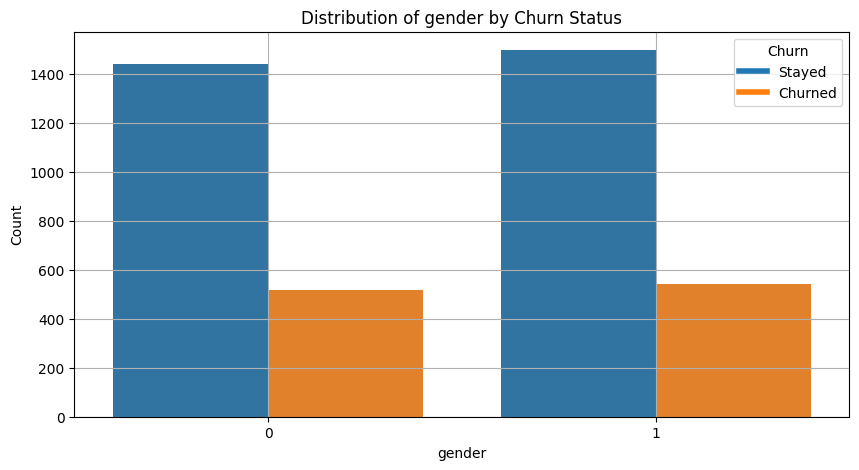

In [11]:
plot_distribution(df, 'gender')

The distribution of gender is similar for both groups, indicating that gender does not significantly affect churn.

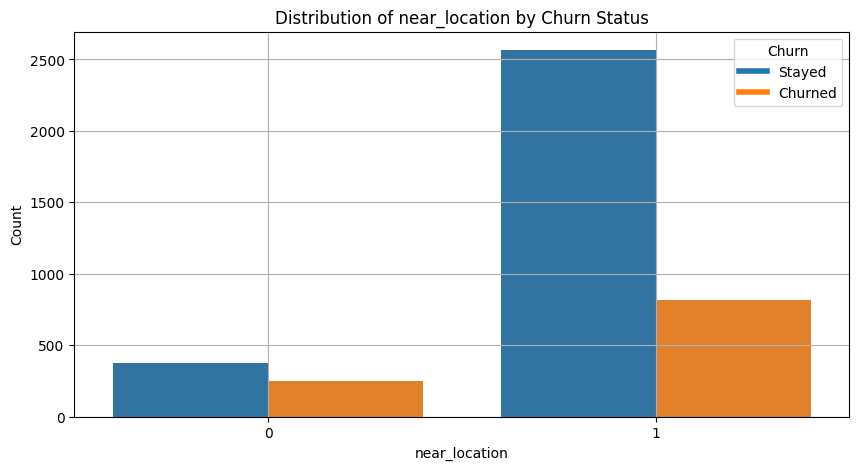

In [12]:
plot_distribution(df, 'near_location')

More customers who stayed live or work near the gym compared to those who churned, suggesting proximity influences retention.

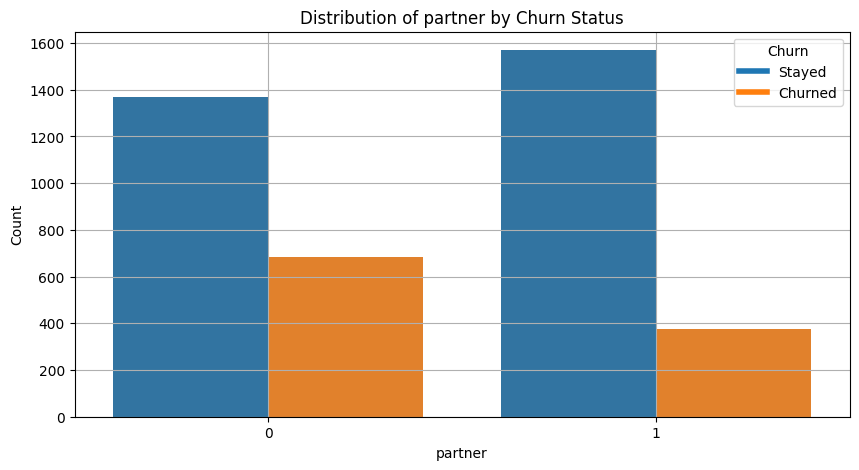

In [13]:
plot_distribution(df, 'partner')

A higher proportion of partner company employees tend to stay compared to those who churn, indicating partner affiliations may help in retaining customers.

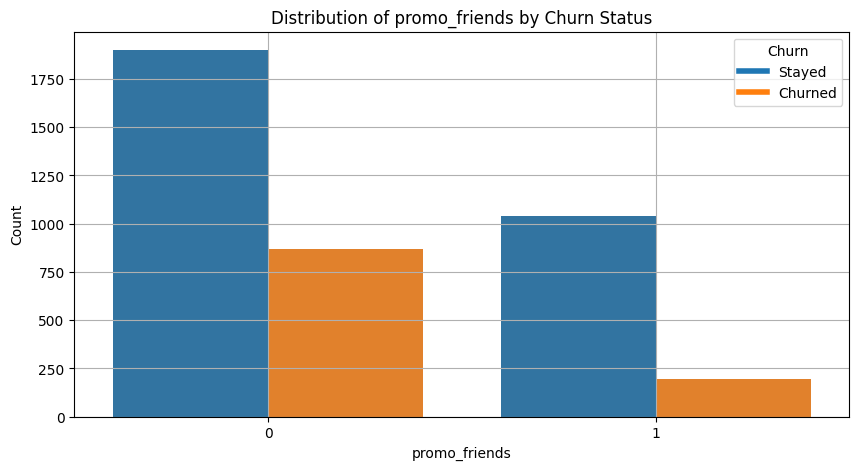

In [14]:
plot_distribution(df, 'promo_friends')

Customers who signed up through a friend's promo code are more likely to stay, showing the importance of social influence in retention.

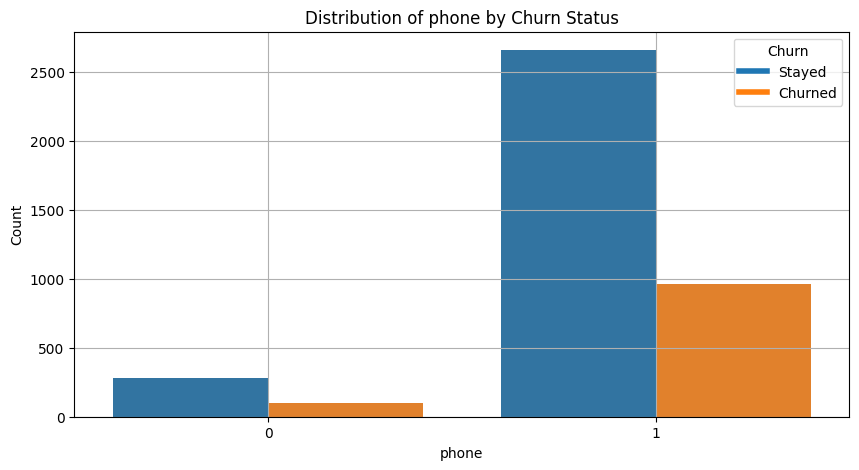

In [15]:
plot_distribution(df, 'phone')

Users that provided a phone number are significantly less likely to churn.

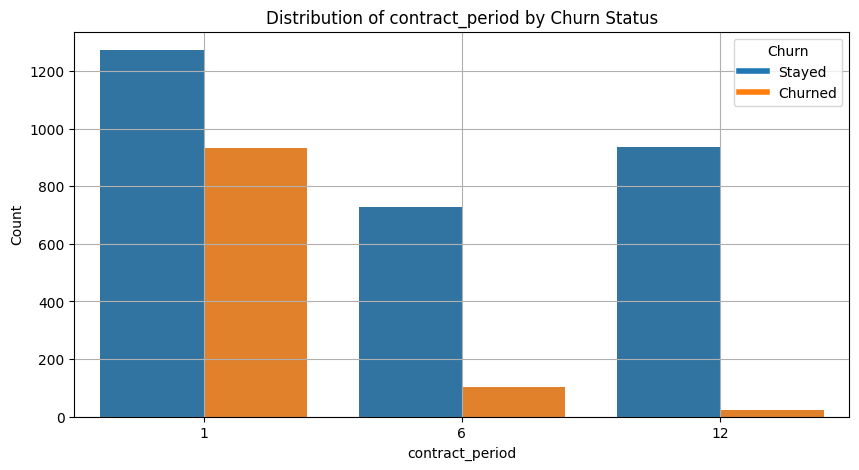

In [16]:
plot_distribution(df, 'contract_period')

Longer contract periods are more common among those who stay, while shorter contracts are more common among those who churn.

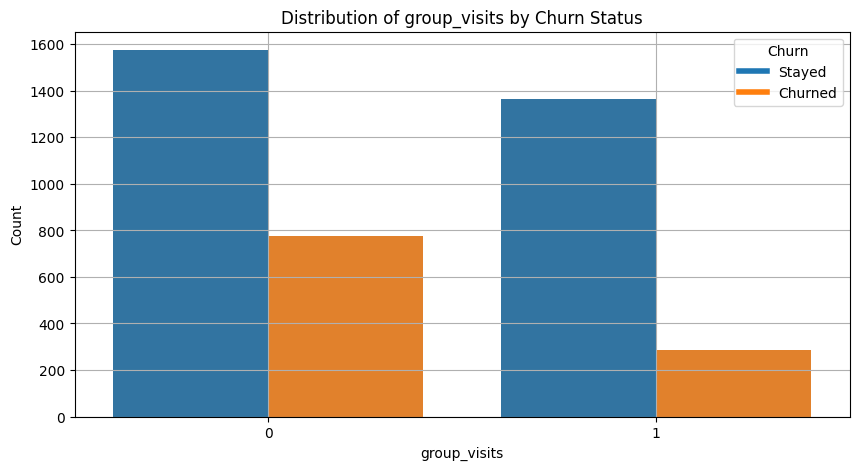

In [17]:
plot_distribution(df, 'group_visits')

Participation in group visits is higher among customers who stay, suggesting that group activities promote retention.

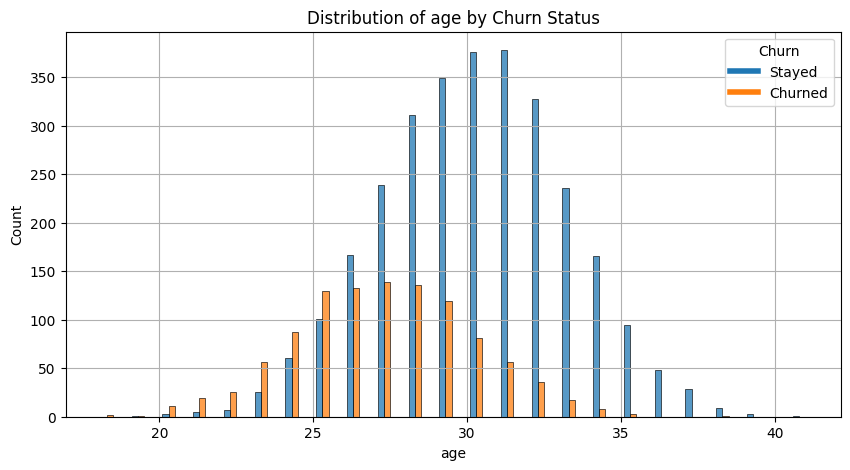

In [18]:
plot_distribution(df, 'age')

Customers who stay are generally older, indicating age might be a factor in retention.

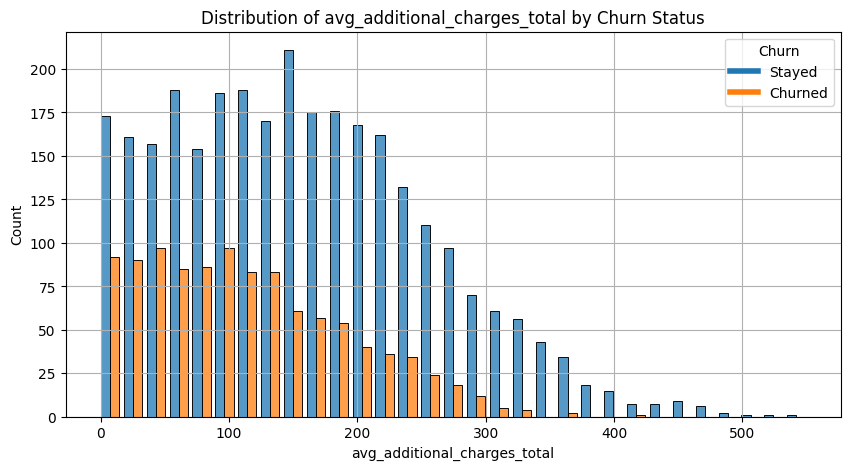

In [19]:
plot_distribution(df, 'avg_additional_charges_total')

Customers who stay tend to spend more on additional services, suggesting higher engagement with the gym's offerings.

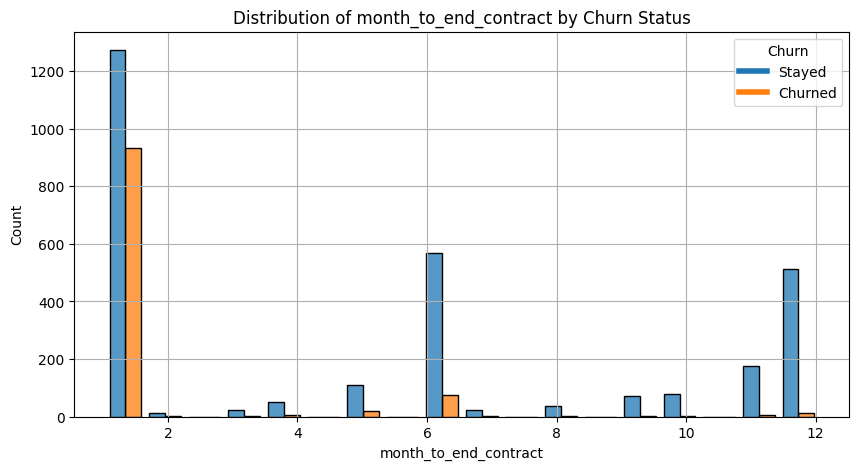

In [20]:
plot_distribution(df, 'month_to_end_contract')

Customers who stay have more months left on their contracts compared to those who churn, indicating contract duration plays a role in retention.

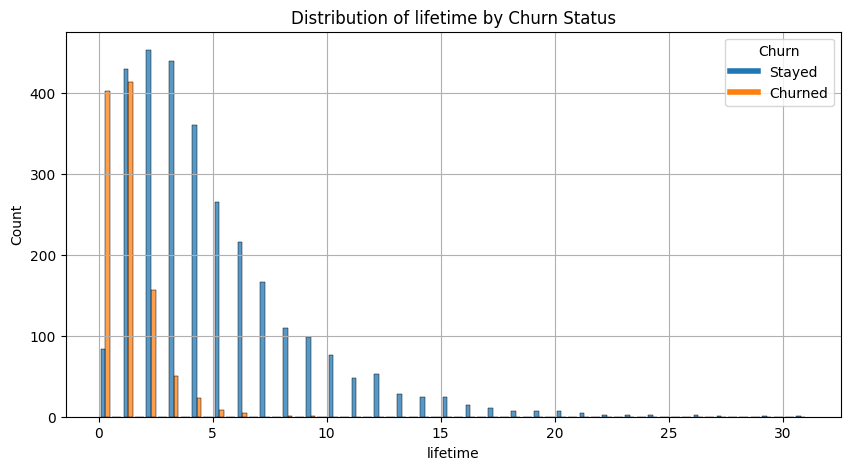

In [21]:
plot_distribution(df, 'lifetime')

Longer lifetimes (months since first visit) are associated with staying customers, while shorter lifetimes are more common among those who churn

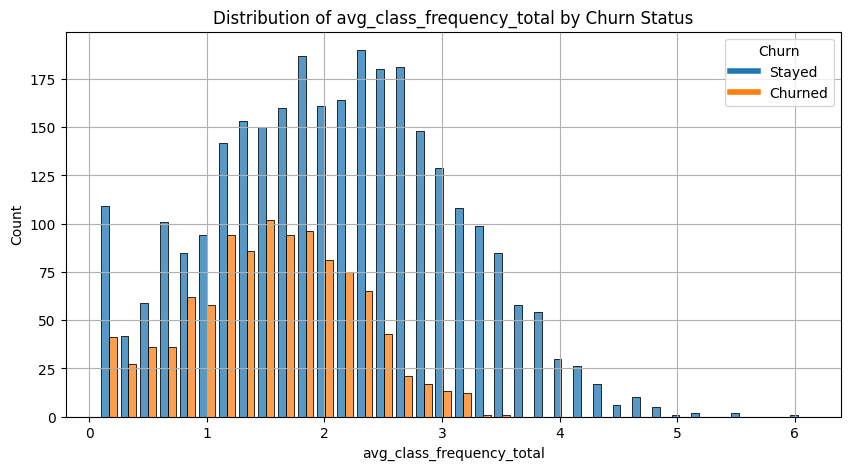

In [22]:
plot_distribution(df, 'avg_class_frequency_total')

Higher average class frequency over the lifetime is seen among those who stay, showing regular attendance correlates with retention.

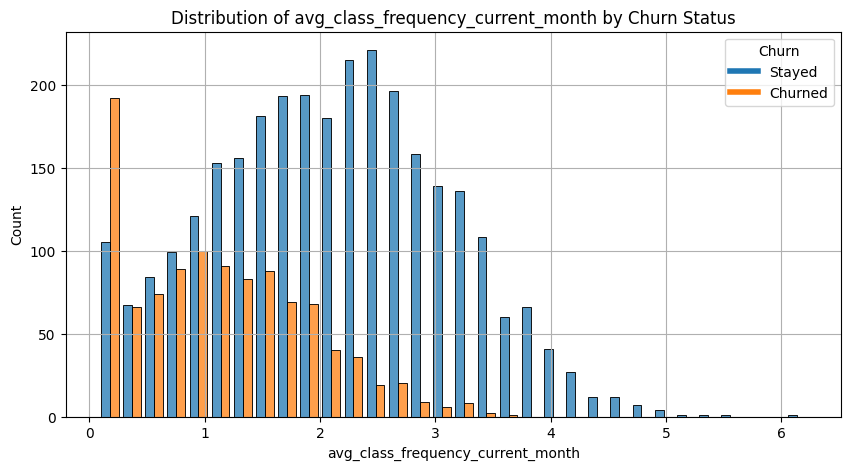

In [23]:
plot_distribution(df, 'avg_class_frequency_current_month')

Similar to the total frequency, higher current month frequency is seen among those who stay, emphasizing the importance of consistent gym visits.

#### Building a correlation matrix.

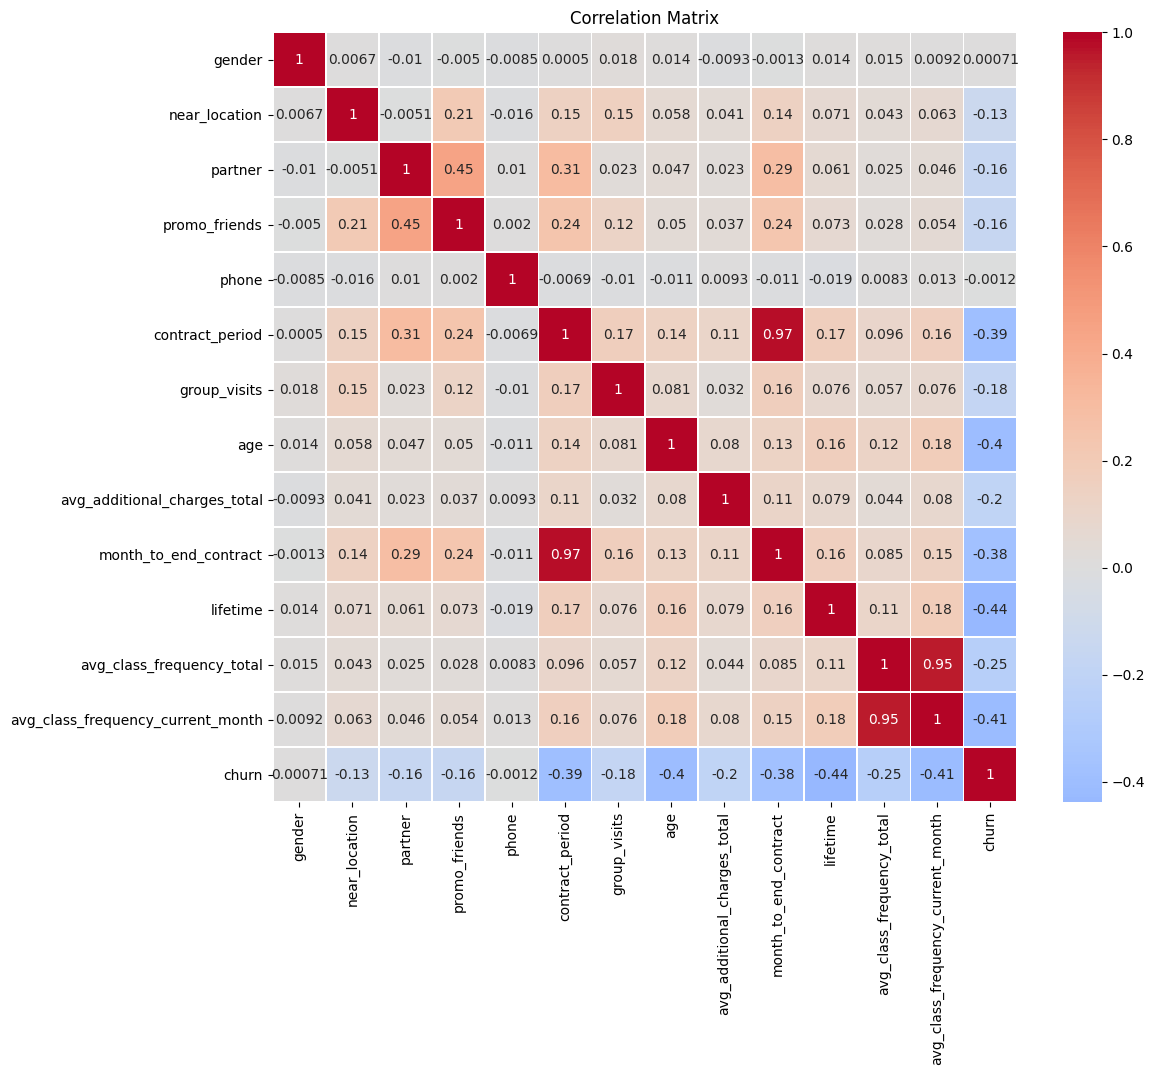

In [24]:
# Build the correlation matrix
correlation_matrix = df.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

We can notice a few strong correlations.
    
**Strong positive correlations:**

    Between 'promo friends' and 'partner' is likely due to some of employes from partnered companies promoting the gym to their friends and/or family members. This could indicate that partner companies effectively use the "bring a friend" promotion to increase gym membership among their employees.
    
    Between 'month to end contract' and 'contract period' is likely because the longer contract periods generally have more months remaining. This makes sense because a longer contract will typically have a higher number of months left compared to a shorter contract.
    
**Strong negative correlations:**

    Between 'lifetime' and 'churn' indicates that customers who have been members for a longer time are less likely to churn. This means that as the lifetime increases, the likelihood of churn decreases. This is a common pattern in membership-based services where long-term members tend to be more loyal and less likely to leave.
    
    Between 'age' and 'churn' indicates that older customers are less likely to churn. As age increases, the likelihood of churning decreases. This could suggest that older customers are more committed or find more value in the gym membership.


<a id='churn'></a>

### User churn

Let's divide our dataset for training.

In [25]:
# Defining the target variable and features

X = df.drop('churn', axis=1)
y = df['churn']

#### Dividing the data into train and validation sets.

In [26]:
# Dividing the data into train and validation sets

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
# Display the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

X_train shape: (3200, 13)
X_val shape: (800, 13)
y_train shape: (3200,)
y_val shape: (800,)


#### Training the model on the train set with Logistic Regression model.

In [28]:
# Training logistic regression model

log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [29]:
# Predicting on validation setb

y_pred_log_reg = log_reg.predict(X_val)

In [30]:
# Evaluating logistic regression model

accuracy_log_reg = accuracy_score(y_val, y_pred_log_reg)
precision_log_reg = precision_score(y_val, y_pred_log_reg)
recall_log_reg = recall_score(y_val, y_pred_log_reg)
classification_report_log_reg = classification_report(y_val, y_pred_log_reg)

#### Training the model on the train set with Random Forest model.

In [31]:
# Training random forest model

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [32]:
# Predicting on validation set

y_pred_rf = rf_clf.predict(X_val)

In [33]:
# Evaluating random forest model

accuracy_rf = accuracy_score(y_val, y_pred_rf)
precision_rf = precision_score(y_val, y_pred_rf)
recall_rf = recall_score(y_val, y_pred_rf)
classification_report_rf = classification_report(y_val, y_pred_rf)

#### Evaluating accuracy, precision, and recall for both models using the validation data. Comparing the models.

In [34]:
print("Logistic Regression Accuracy:", accuracy_log_reg)
print("Logistic Regression Precision:", precision_log_reg)
print("Logistic Regression Recall:", recall_log_reg)
print("Logistic Regression Classification Report:")
print(classification_report(y_val, y_pred_log_reg))

Logistic Regression Accuracy: 0.91625
Logistic Regression Precision: 0.8729281767955801
Logistic Regression Recall: 0.7821782178217822
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       598
           1       0.87      0.78      0.83       202

    accuracy                           0.92       800
   macro avg       0.90      0.87      0.89       800
weighted avg       0.91      0.92      0.91       800



In [35]:
print("Random Forest Accuracy:", accuracy_rf)
print("Random Forest Precision:", precision_rf)
print("Random Forest Recall:", recall_rf)
print("Random Forest Classification Report:")
print(classification_report(y_val, y_pred_rf))

Random Forest Accuracy: 0.91
Random Forest Precision: 0.8494623655913979
Random Forest Recall: 0.7821782178217822
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       598
           1       0.85      0.78      0.81       202

    accuracy                           0.91       800
   macro avg       0.89      0.87      0.88       800
weighted avg       0.91      0.91      0.91       800



Both models perform similarly in terms of accuracy. Logistic Regression has a slight edge in precision, while Random Forest has a slight edge in recall. The choice between the two models may depend on whether you prioritize precision (fewer false positives) or recall (fewer false negatives).

<a id='clusters'></a>

### User clusters

#### Standardizing the data.

In [36]:
# Standardize the data

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [37]:
# Convert the scaled data back to a DataFrame

X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled_df.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
0,0.979706,0.427881,1.026861,1.497161,-3.059852,0.289890,1.194032,-0.056554,-1.377531,0.161605,-0.193329,-1.911920,-1.678472
1,-1.020715,0.427881,-0.973842,-0.667931,0.326813,1.608822,1.194032,0.557327,-0.350213,1.831941,0.873680,0.045176,0.136014
2,-1.020715,0.427881,1.026861,-0.667931,0.326813,-0.809219,-0.837498,-0.363494,-0.181592,-0.792873,-0.460081,-0.020493,-0.029019
3,-1.020715,0.427881,1.026861,1.497161,0.326813,1.608822,1.194032,1.171208,-0.874722,1.831941,-0.460081,1.364655,1.510450
4,0.979706,0.427881,1.026861,1.497161,0.326813,-0.809219,-0.837498,-0.977375,0.533700,-0.792873,-0.193329,-0.787076,-0.614542


#### Building a matrix of distances based on the standardized feature matrix and plotting a dendrogram. Using the resulting graph to estimate the number of clusters we can single out.

In [38]:
# Build the linkage matrix

linkage_matrix = sch.linkage(X_scaled, method='ward')

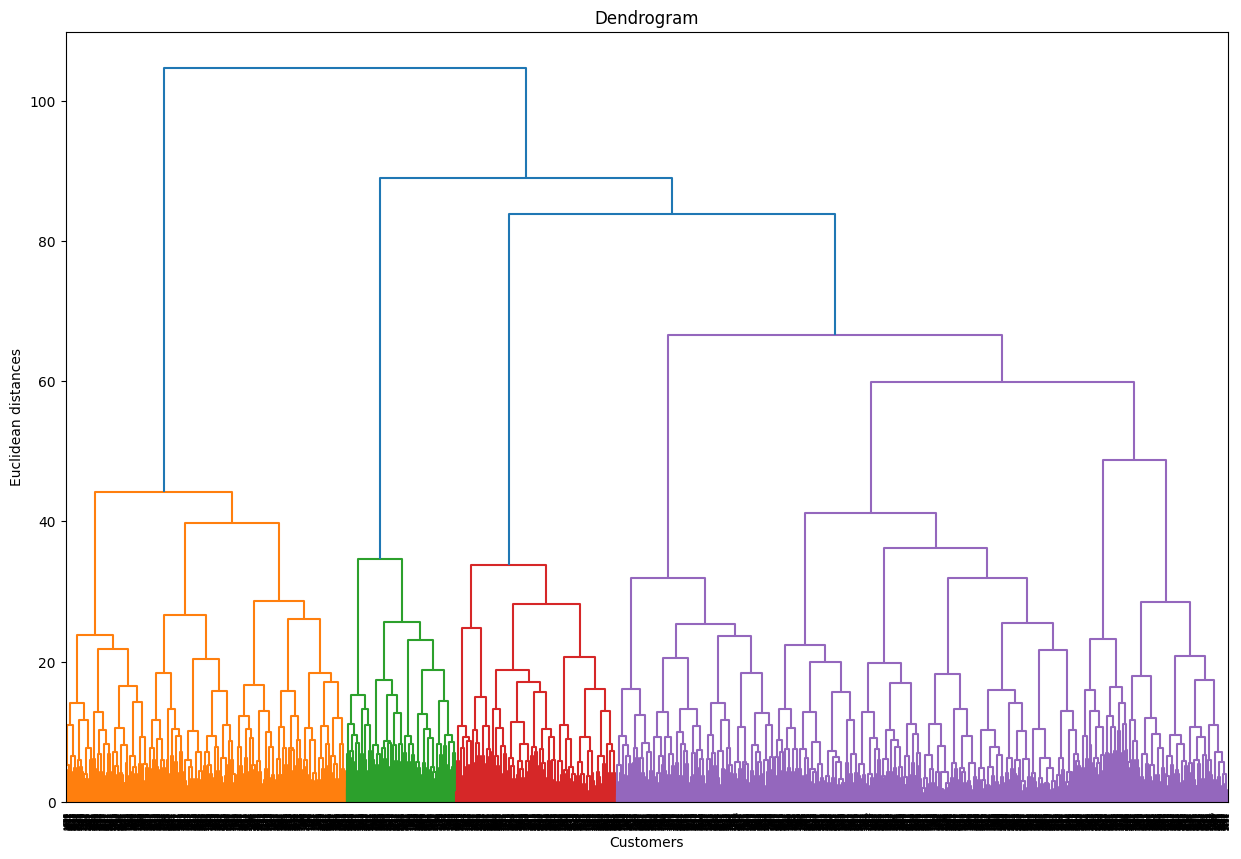

In [39]:
# Plot the dendrogram

plt.figure(figsize=(15, 10))
dendrogram = sch.dendrogram(linkage_matrix)
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

#### Training the clustering model with the K-means algorithm and predict customer clusters.

In [40]:
# Train the K-means clustering model

kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_scaled)

KMeans(n_clusters=5, random_state=42)

In [41]:
# Predict customer clusters

clusters = kmeans.predict(X_scaled)

In [42]:
# Add the cluster assignments to the original dataframe

df['cluster'] = clusters
df.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn,cluster
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0,4
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0,2
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0,3
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0,2
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0,0


In [57]:
# Displaying each cluster size

print('Cluster 0 size :',df[df.cluster == 0].shape)
print()
print('Cluster 1 size :',df[df.cluster == 1].shape)
print()
print('Cluster 2 size :',df[df.cluster == 2].shape)
print()
print('Cluster 3 size :',df[df.cluster == 3].shape)
print()
print('Cluster 4 size :',df[df.cluster == 4].shape)

Cluster 0 size : (633, 15)

Cluster 1 size : (889, 15)

Cluster 2 size : (865, 15)

Cluster 3 size : (1227, 15)

Cluster 4 size : (386, 15)


#### Looking at the mean feature values for clusters. 

In [45]:
# Calculating the mean feature values for each cluster

df.groupby('cluster').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster,,,,,,,,,,,,,,
0,0.502370,0.949447,0.829384,0.998420,1.0,3.097946,0.448657,29.104265,141.774331,2.887836,3.772512,1.770536,1.669581,0.246445
1,0.554556,0.849269,0.263217,0.052868,1.0,2.606299,0.436445,30.008999,159.774265,2.419573,4.780652,2.745505,2.733173,0.089989
2,0.499422,0.937572,0.737572,0.478613,1.0,11.854335,0.546821,29.905202,163.509804,10.812717,4.677457,2.006405,1.998179,0.021965
3,0.485738,0.718011,0.299919,0.018745,1.0,1.914425,0.276284,28.083945,129.496414,1.821516,2.195599,1.225192,0.967967,0.572942
4,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,4.466321,3.940415,1.854211,1.723967,0.266839


Main takeaways from each cluster:

- Cluster 0: Characterized by proximity to the gym, partner company employees, and friend promotions. Moderate churn;
- Cluster 1: Frequent gym visitors who did not use friend promotions. Low churn;
- Cluster 2: Long contract periods and many months remaining. Very low churn;
- Cluster 3: Low proximity, infrequent visits, and rare use of friend promotions. High churn; 
- Cluster 4: Moderate use of friend promotions and months remaining on contracts. Moderate churn.

In [117]:
# Function to plot distribution of a feature for the clusters

def plot_feature_distribution(df, feature):
    plt.figure(figsize=(24, 14))  
    sns.histplot(data=df, x=feature, hue='cluster', multiple='dodge', shrink=0.8, kde=False, palette="tab10")
    plt.title(f'Distribution of {feature} by Cluster', fontsize=16)  
    plt.xlabel(feature, fontsize=14) 
    plt.ylabel('Count', fontsize=14)
    plt.xticks(fontsize=12)  
    plt.yticks(fontsize=12) 
    plt.grid(True)
    plt.show()

#### Plotting distributions of features for the clusters.

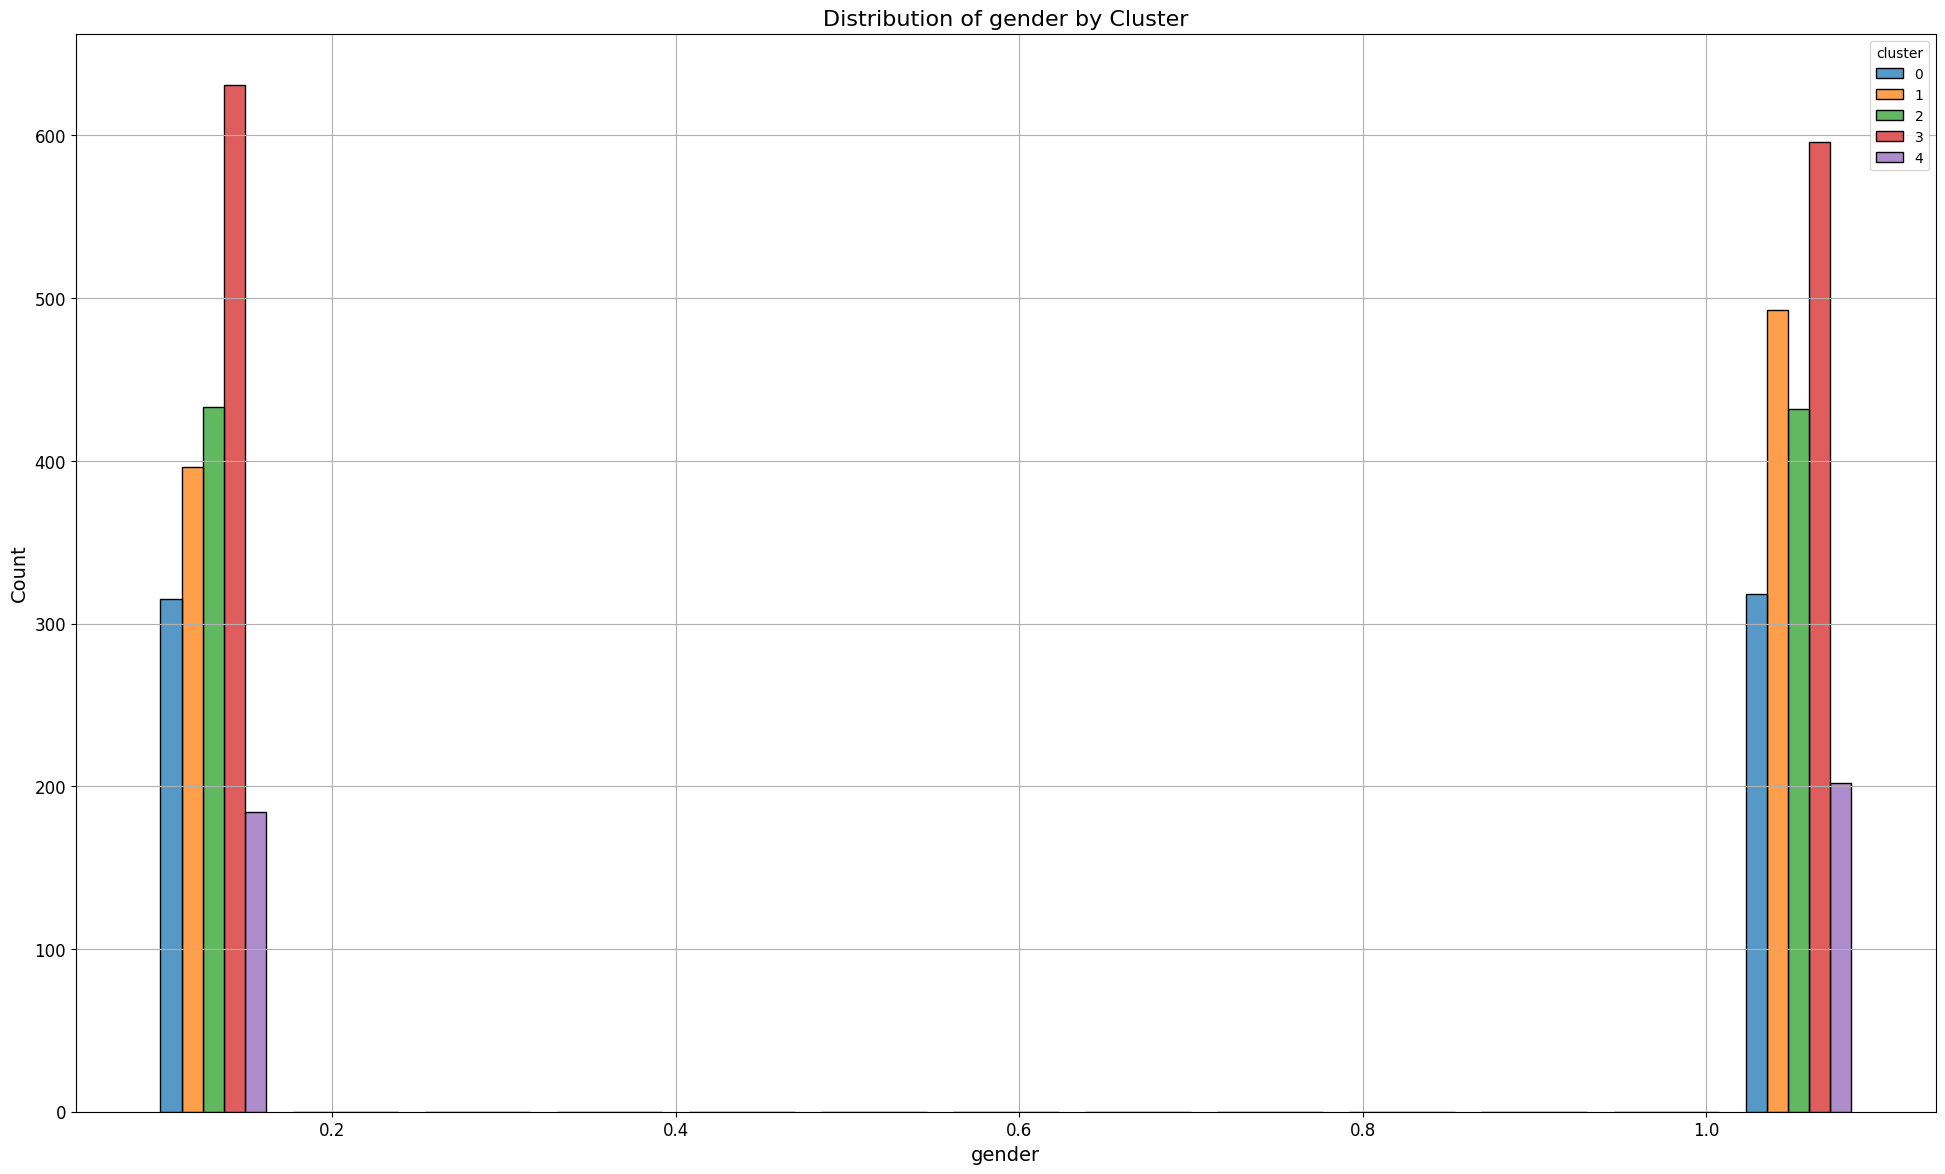

In [118]:
plot_feature_distribution(df, 'gender')

Almost equal ditribution between genders within clusters.

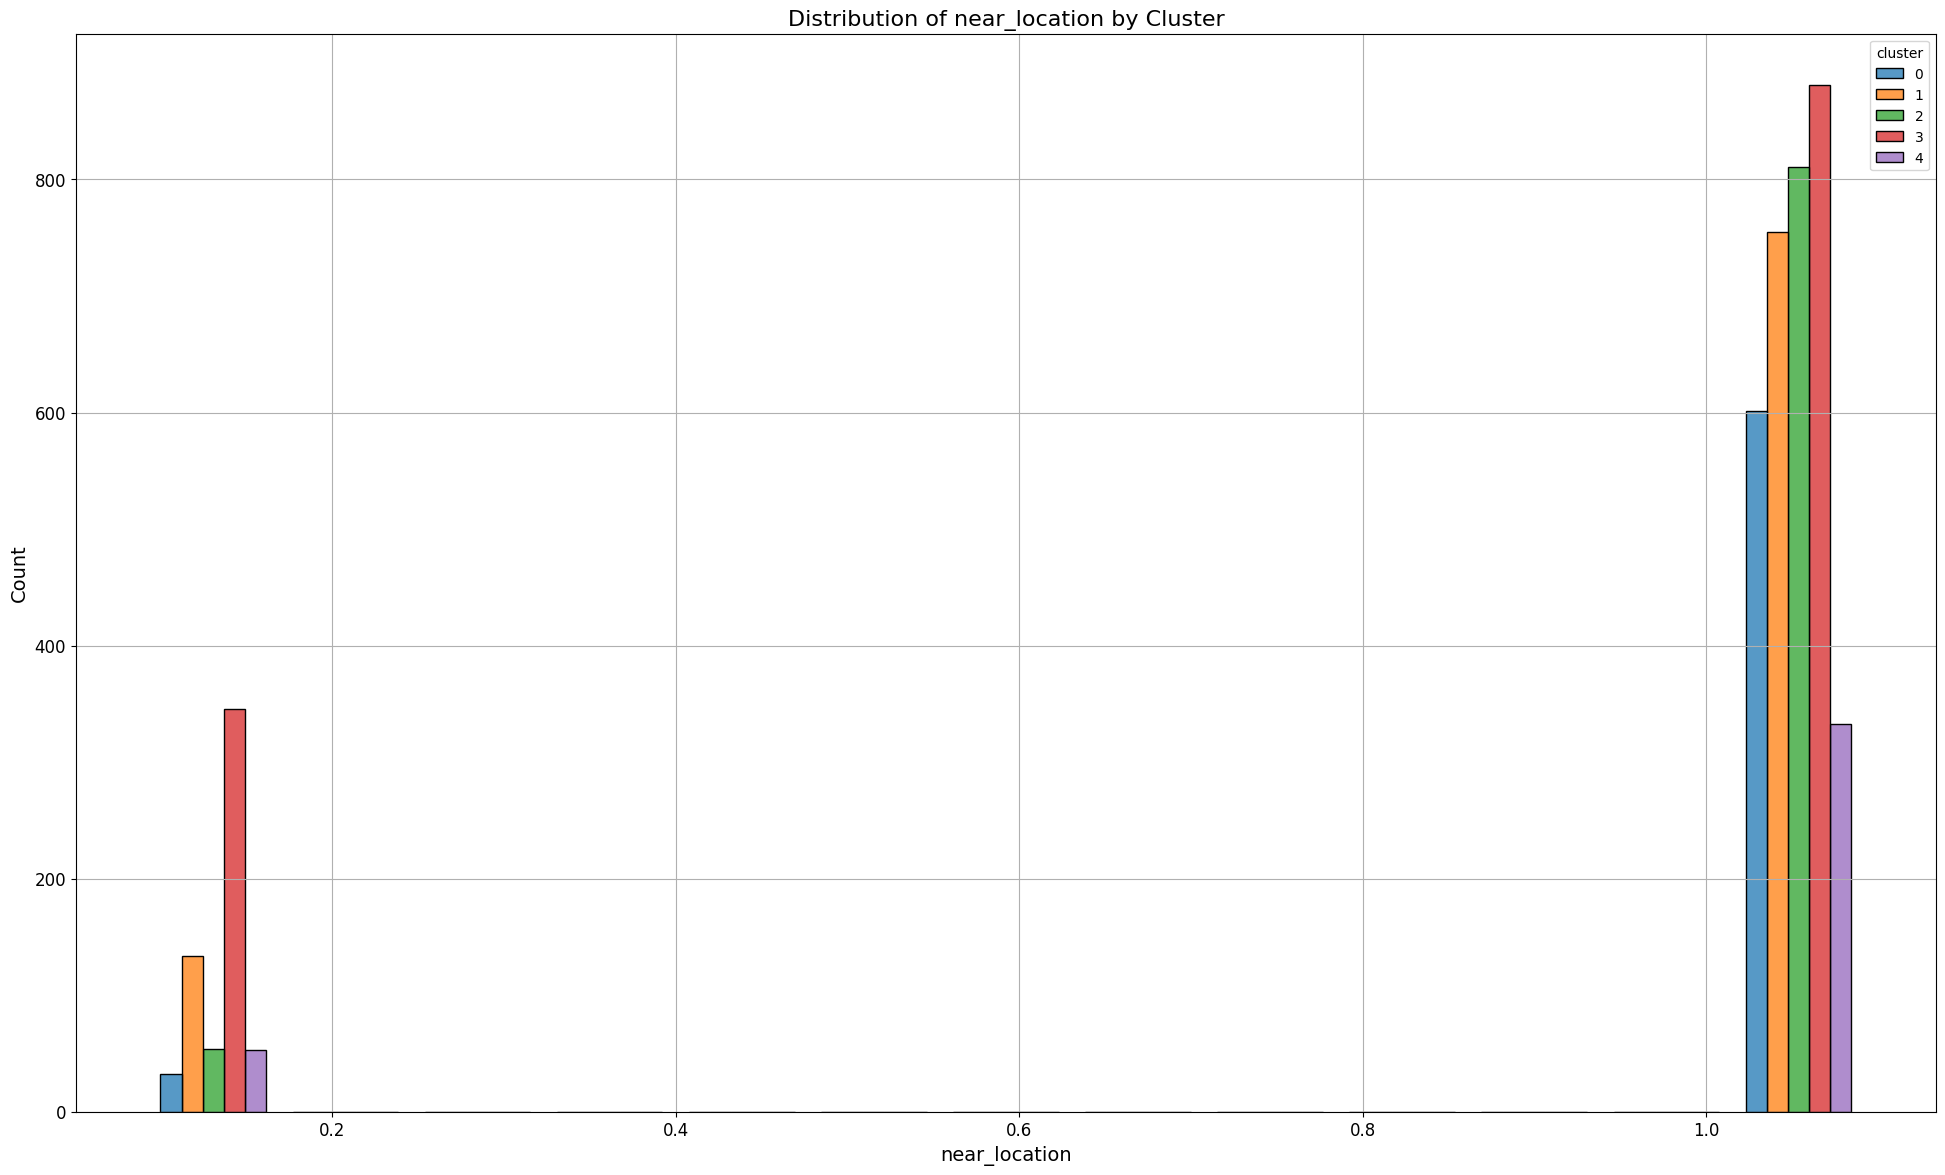

In [119]:
plot_feature_distribution(df, 'near_location')

We have a lot more customers that are located closer to the gym, the distribution seems normal.

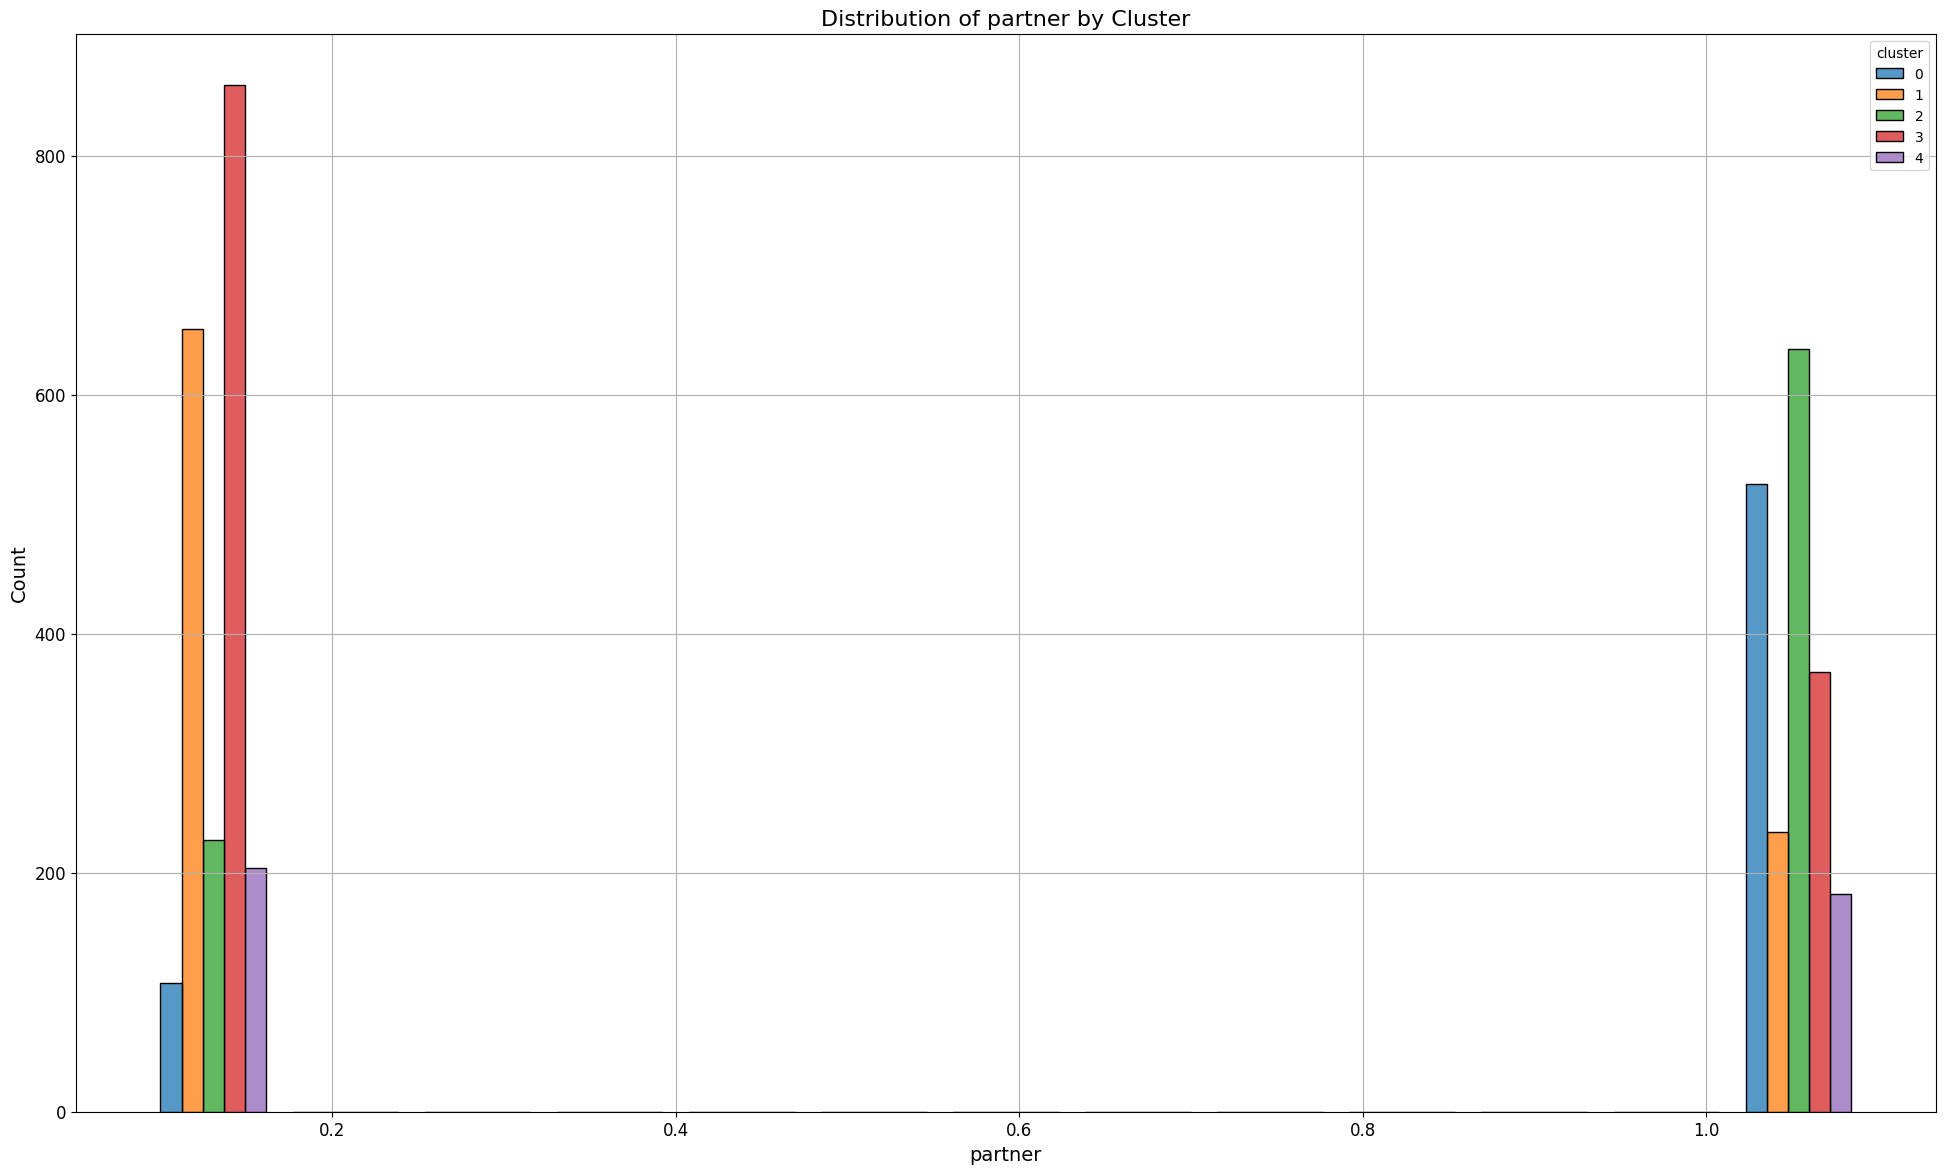

In [120]:
plot_feature_distribution(df, 'partner')

Here we notice something interesting. The majority of customers in Cluster 0 are partner company employees. This cluster is likely to benefit significantly from corporate membership programs and discounts offered to partner companies. Same with Cluster 2. Clusters 1 and 3 have a larger number of non-partner employees, indicating that these customers joined the gym through other means, such as individual memberships or promotions not related to partner companies. It also indicates different recruitment strategies or customer demographics compared to Clusters 0 and 2. Cluster 4  has a more balanced mix of partner and non-partner employees, suggesting a diverse customer base with varied membership sources.

**Practical Implications:**

 - *Corporate Membership Programs*:
    - Clusters 0 and 2: These clusters are heavily influenced by corporate memberships. Enhance corporate partnerships, offer exclusive corporate discounts, and create targeted marketing campaigns to retain and attract more partner company employees;
    - Clusters 1 and 3: Focus on individual membership promotions and personalized marketing strategies to attract non-partner employees. Consider offering special promotions or incentives to convert these customers into long-term members;
    - Cluster 4: Develop a balanced approach to cater to both partner and non-partner employees. Offer flexible membership options and diverse services to meet the needs of a varied customer base.

 - *Retention Strategies*:
    - Clusters 0 and 2: Implement loyalty programs and exclusive benefits for partner company employees to enhance retention. Regularly engage with corporate clients to ensure satisfaction and renew partnerships;
    - Clusters 1 and 3: Focus on personalized engagement strategies and customer satisfaction surveys to understand the needs and preferences of non-partner employees. Offer personalized incentives to improve retention rates.

 - *Service Offerings*:
    - Clusters 0 and 2: Provide corporate wellness programs, group activities, and company-specific events to enhance the gym experience for partner company employees;
    - Clusters 1 and 3: Offer a variety of fitness classes, individual coaching sessions, and flexible membership plans to cater to the diverse preferences of non-partner employees.

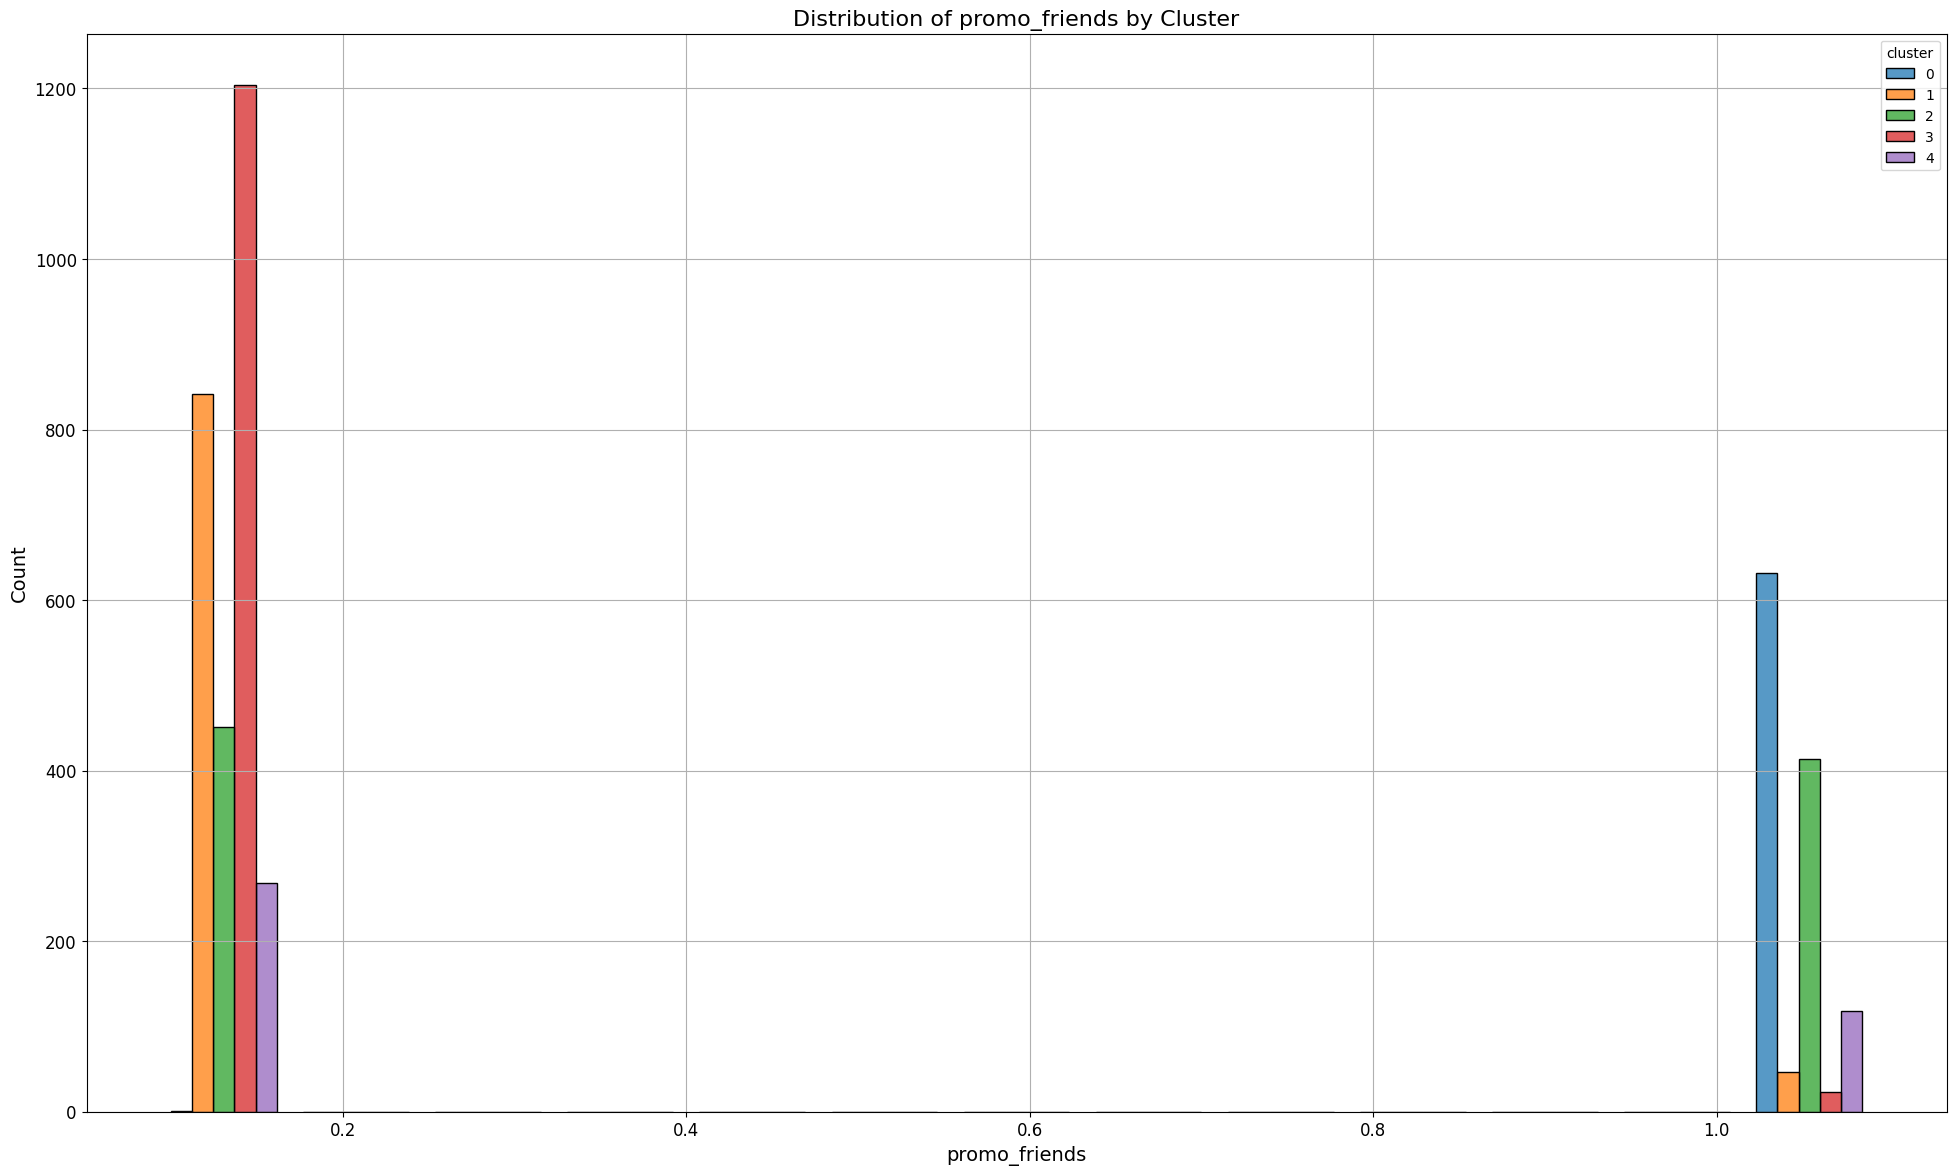

In [121]:
plot_feature_distribution(df, 'promo_friends')

Almost all of the customers in Cluster 0 signed up through friend promotions, in fact, it's the majority of all those that have signed up with the program. Cluster 1 has very few customers who joined through friend promotions, indicating that other marketing or recruitment methods were more effective for these members, same with Cluster 3. Cluster 2 has a mix of customers who joined through friend promotions and those who did not, indicating diverse recruitment strategies, same with Cluster 4.

**Practical Implications:**

- *Referral Program Effectiveness*:
    - Cluster 0: Indicates that the referral program is highly effective for this cluster. Enhance and promote the "bring a friend" program to attract more customers through social referrals;
    - Clusters 1 and 3: Indicates low effectiveness of referral programs. Investigate other successful recruitment methods used for these clusters and consider alternative strategies to increase referrals.

- *Marketing Strategies*:
     - Cluster 2: Shows a balanced recruitment strategy. Maintain a mix of referral-based and other marketing efforts to attract a diverse customer base;
    - Cluster 4: Indicates moderate success of referral programs. Strengthen and promote referral incentives to increase their effectiveness.

- *Retention Strategies*:
    - Cluster 0: Focus on maintaining high satisfaction levels for customers brought in through referrals. Offer referral bonuses and loyalty programs to encourage continued engagement;
    - Clusters 1 and 3: Focus on personalized engagement and retention strategies for customers who joined through other means. Consider targeted promotions and personalized communication to improve retention rates.

- *Service Offerings*:
    - Cluster 0: Leverage social aspects of the gym, such as group classes and events, to maintain the interest of customers who joined through referrals;
    - Clusters 1 and 3: Offer a variety of individual and group activities to cater to the diverse preferences of customers who did not join through referrals.

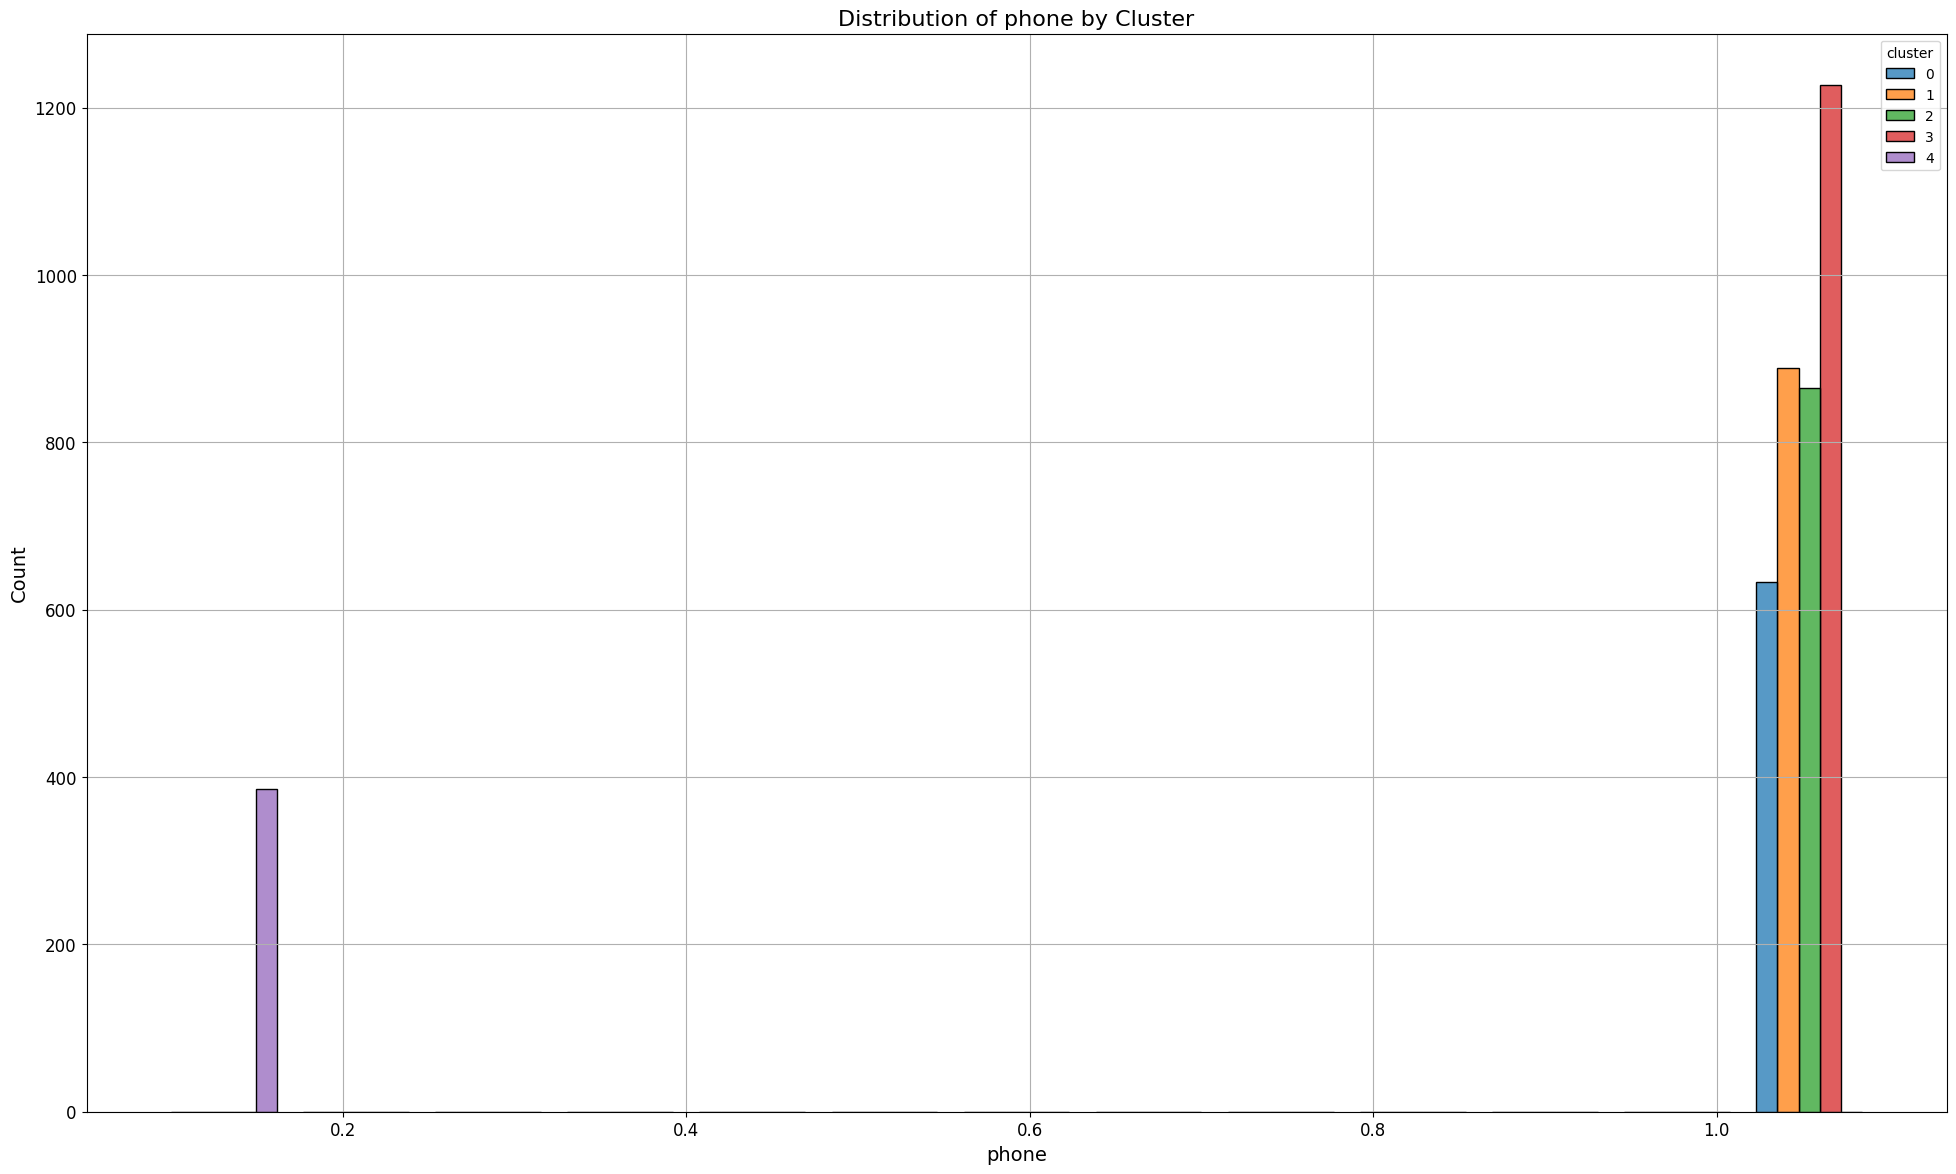

In [122]:
plot_feature_distribution(df, 'phone')

Interesting ditribution on this graph. All customers from Cluster 4 have not listed their phone numbers, indicating a preference for privacy or other modes of communication. On the other hand, customers in Clusters 0, 1, 2 and 3 are highly engaged and willing to share their contact information. This could facilitate communication and engagement strategies through phone calls or SMS.

**Practical Implications:**

- *Communication Strategies*:
    - Clusters 0, 1, 2, 3: Since all customers in these clusters provided their phone numbers, leverage phone-based communication strategies such as personalized SMS offers, feedback calls, and service reminders to enhance engagement and retention;
    - Cluster 4: Explore alternative communication methods such as email, in-app notifications, or social media, as these customers did not provide their phone numbers.

- *Engagement Strategies*:
    - Clusters 0, 1, 2, 3: Use phone numbers to conduct satisfaction surveys, provide personalized fitness advice, and promote new services or offers. Ensure that communication is relevant and not overly intrusive to maintain high engagement;
    - Cluster 4: Focus on building trust and demonstrating value through non-phone communication channels. Consider incentives or clear explanations of benefits to encourage future provision of contact information.

- *Privacy Considerations*:
    - Cluster 4: Respect the privacy preferences of customers who did not provide their phone numbers. Ensure that data privacy policies are transparent and that customers feel secure in how their information is used.

- *Marketing and Promotions*:
    - Clusters 0, 1, 2, 3: Implement targeted marketing campaigns using phone numbers for timely and direct promotions. Offer exclusive deals or early access to new services via SMS to drive engagement;
    - Cluster 4: Develop marketing strategies that rely on email, online ads, and social media to reach these customers. Highlight the benefits of providing contact information in future interactions.

- *Customer Service*:
    - Clusters 0, 1, 2, 3: Enhance customer service by providing personalized support through phone calls. Use phone numbers to quickly address customer issues and improve satisfaction;
    - Cluster 4: Ensure that customer service is accessible through multiple channels such as email, chat, and social media, catering to customers' preferences for non-phone communication.

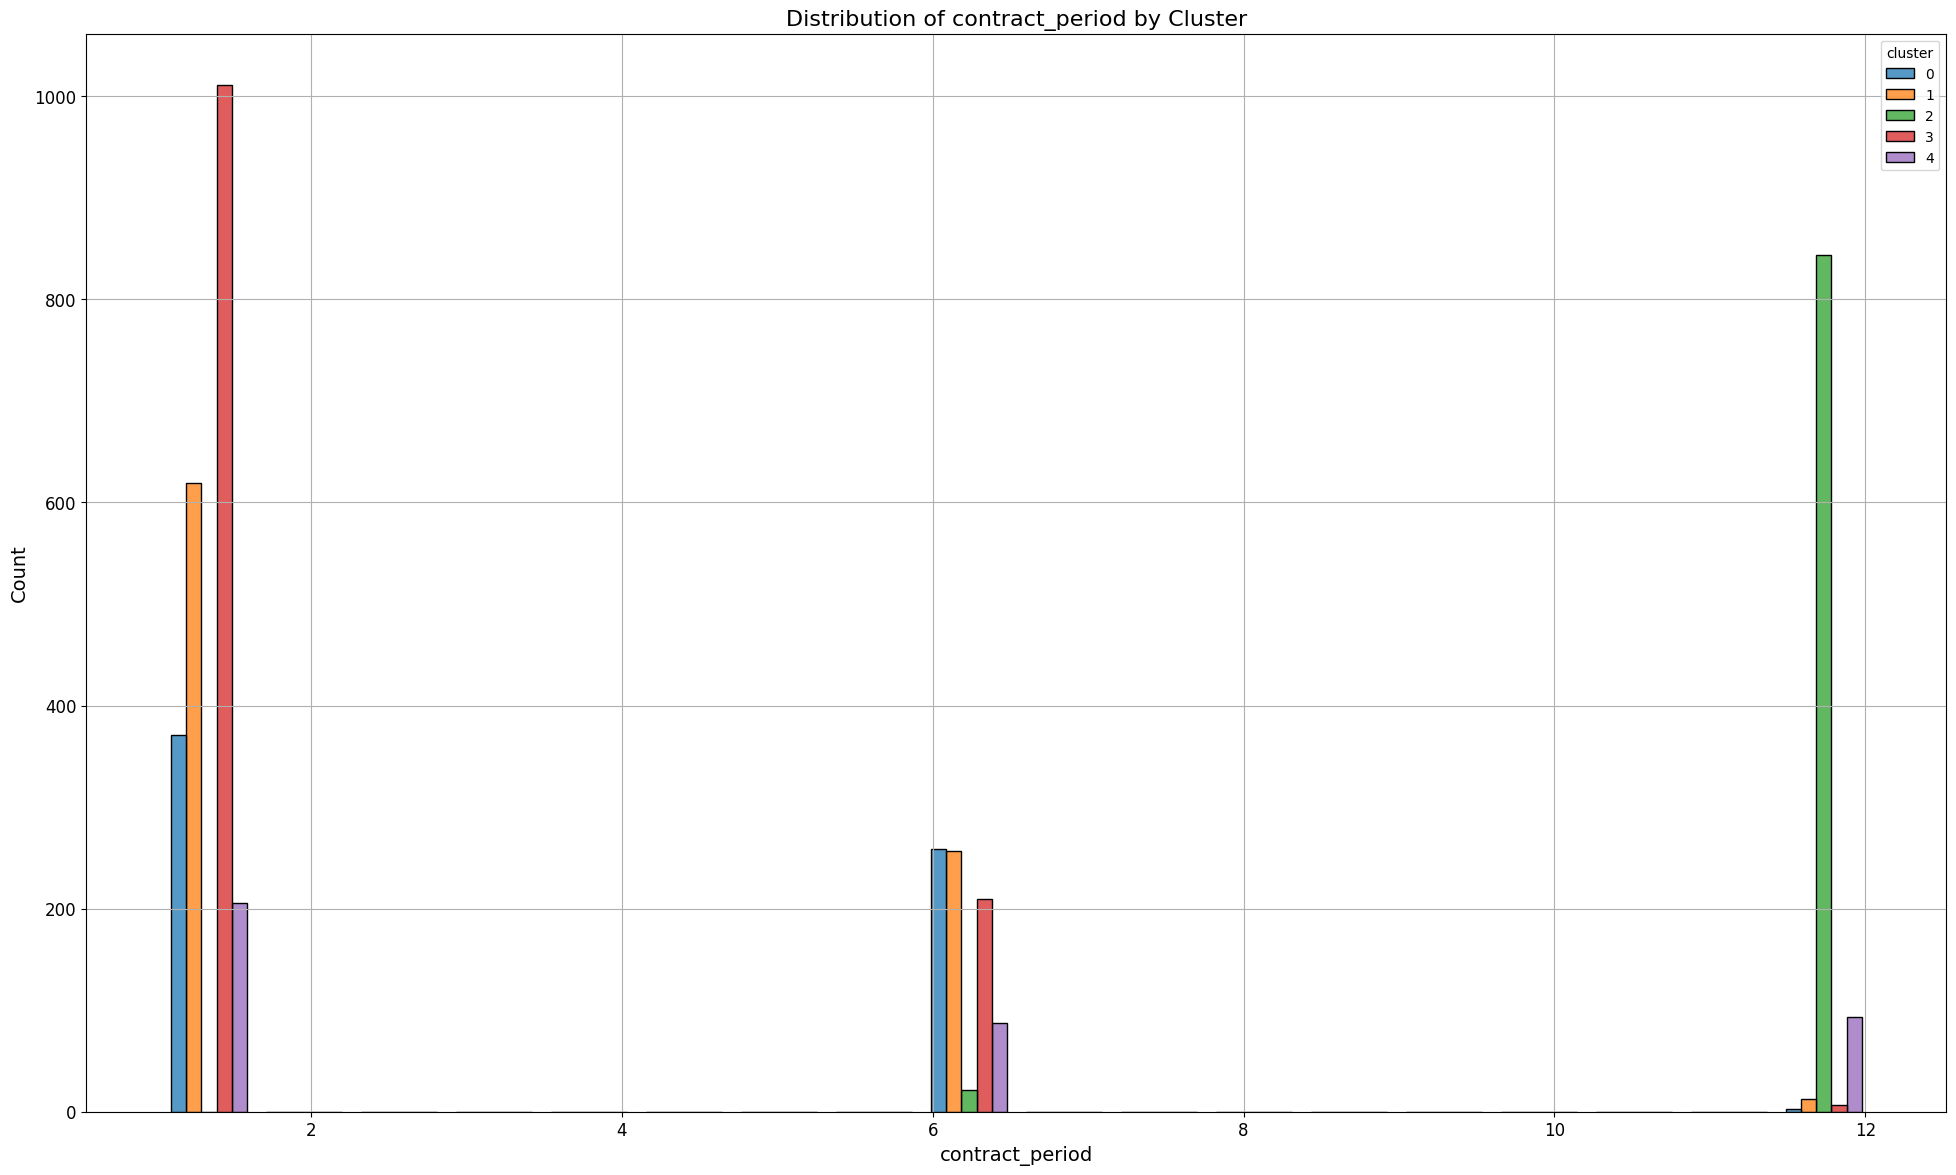

In [123]:
plot_feature_distribution(df, 'contract_period')

Main takeaways from this graph are that:
 - customers in Cluster 0 prefer short to moderate contract periods. They might be testing the gym services or prefer shorter commitments. Same thing more or less goes for Clusters 1 and 3;
 - customers in Cluster 2 prefer long-term commitments, indicating high confidence in the gym's services and a desire for stability;
 - customers in Cluster 4 prefer moderate contract periods, balancing commitment and flexibility.
 
**Practical Implications:**

- *Membership Plans*:
    - Cluster 0: Offer attractive 3-month membership plans with flexible renewal options. Highlight the benefits of these mid-term plans;
    - Cluster 1: Focus on promoting short-term memberships (1 to 3 months) with the option to upgrade to longer terms. Emphasize flexibility and no long-term commitment;
    - Cluster 2: Promote long-term memberships (12 months) with added benefits such as discounted rates, loyalty rewards, and exclusive access to services. Highlight the value and stability of long-term plans;
    - Cluster 3: Offer highly flexible 1-month memberships and emphasize the ease of joining and leaving. Provide incentives for extending membership duration;
    - Cluster 4: Promote 3 to 6-month memberships as a balance between commitment and flexibility. Highlight special offers for these moderate-term plans.

- *Retention Strategies*:
    - Cluster 0: Engage customers with mid-term commitment through personalized check-ins and renewal reminders. Offer incentives for extending their membership;
    - Cluster 1: Focus on engaging short-term members early to convert them into longer-term members. Provide exceptional service and targeted offers to encourage renewal;
    - Cluster 2: Maintain high engagement with long-term members through regular updates, exclusive events, and loyalty programs. Ensure continuous value delivery to retain them;
    - Cluster 3: Provide a seamless experience for 1-month members and highlight the benefits of staying longer. Offer trial extensions or discounts for longer commitments;
    - Cluster 4: Encourage moderate-term members to upgrade to longer-term plans by showcasing additional benefits and providing renewal incentives.

- *Marketing and Promotions*:
    - Cluster 0: Use targeted marketing campaigns to highlight the benefits of 3-month memberships. Emphasize flexibility and value for money;
    - Cluster 1: Promote short-term plans aggressively, highlighting the no-commitment aspect and easy sign-up process;
    - Cluster 2: Focus marketing efforts on the stability and value of long-term memberships. Use testimonials and success stories from long-term members;
    - Cluster 3: Emphasize the ease and flexibility of 1-month memberships in marketing campaigns. Offer introductory discounts to attract new customers;
    - Cluster 4: Highlight the balanced nature of 3 to 6-month plans in promotions. Showcase special offers and value-added services for these plans.

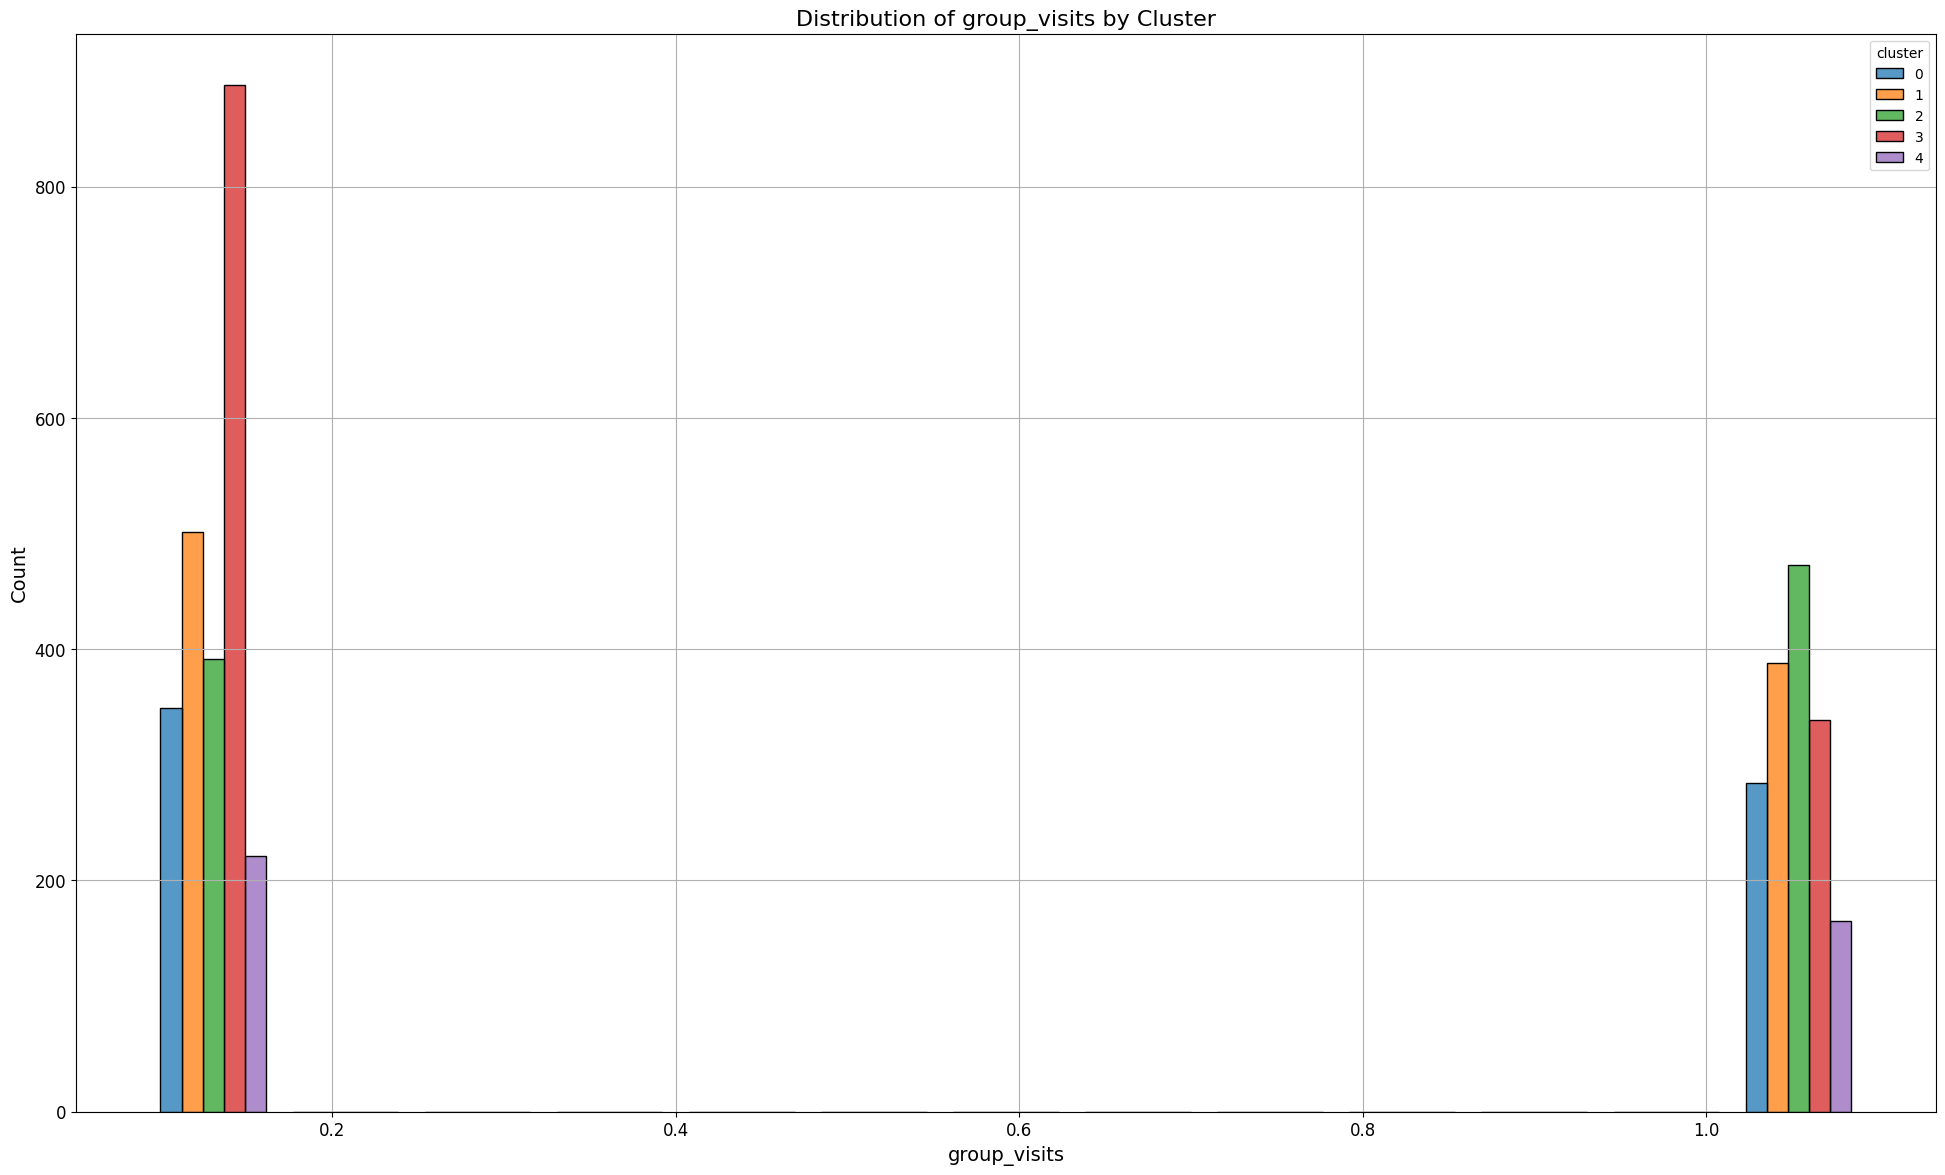

In [124]:
plot_feature_distribution(df, 'group_visits')

For one reason or another, majority of customers in Cluster 3 prefer to visit the gym alone. Every other group of customers has a more equal distribution.

**Practical Implications:**

- *Program Offerings*:
    - Clusters 0, 1, 4: Offer a mix of individual and group workout options. Ensure that both types of activities are well-promoted and accessible;
    - Cluster 2: Focus on enhancing group activity offerings. Introduce new group classes, team-based challenges, and social events to cater to the high interest in group sessions;
    - Cluster 3: Provide more individual workout options and personalized training programs. Highlight the benefits of personal training sessions and individual workout plans.

- *Marketing Strategies*:
    - Clusters 0, 1, 4: Use balanced marketing strategies that promote both individual and group activities. Highlight the variety of options available at the gym;
    - Cluster 2: Emphasize group activities in marketing campaigns. Showcase testimonials from members who enjoy group sessions and create promotional content around group classes and events;
    - Cluster 3: Focus marketing efforts on the benefits of individual workouts. Highlight success stories from members who prefer personal training and individual fitness plans.

- *Retention Strategies*:
    - Clusters 0, 1, 4: Implement retention programs that cater to both individual and group activity preferences. Offer flexible membership plans that include access to both types of activities;
    - Cluster 2: Engage members with exclusive group activity events, challenges, and competitions. Create a community atmosphere that encourages participation in group sessions;
    - Cluster 3: Provide personalized engagement and support for members who prefer individual workouts. Offer one-on-one coaching sessions and personalized fitness plans to enhance their experience.

- *Customer Experience*:
    - Clusters 0, 1, 4: Ensure a variety of options are available to cater to different preferences. Provide a balanced schedule of group classes and individual workout opportunities;
    - Cluster 2: Enhance the group activity experience by providing high-quality instructors, well-equipped group class spaces, and a variety of class types;
    - Cluster 3: Focus on creating a welcoming environment for individual workouts. Ensure that personal trainers are accessible and provide high-quality, individualized support.

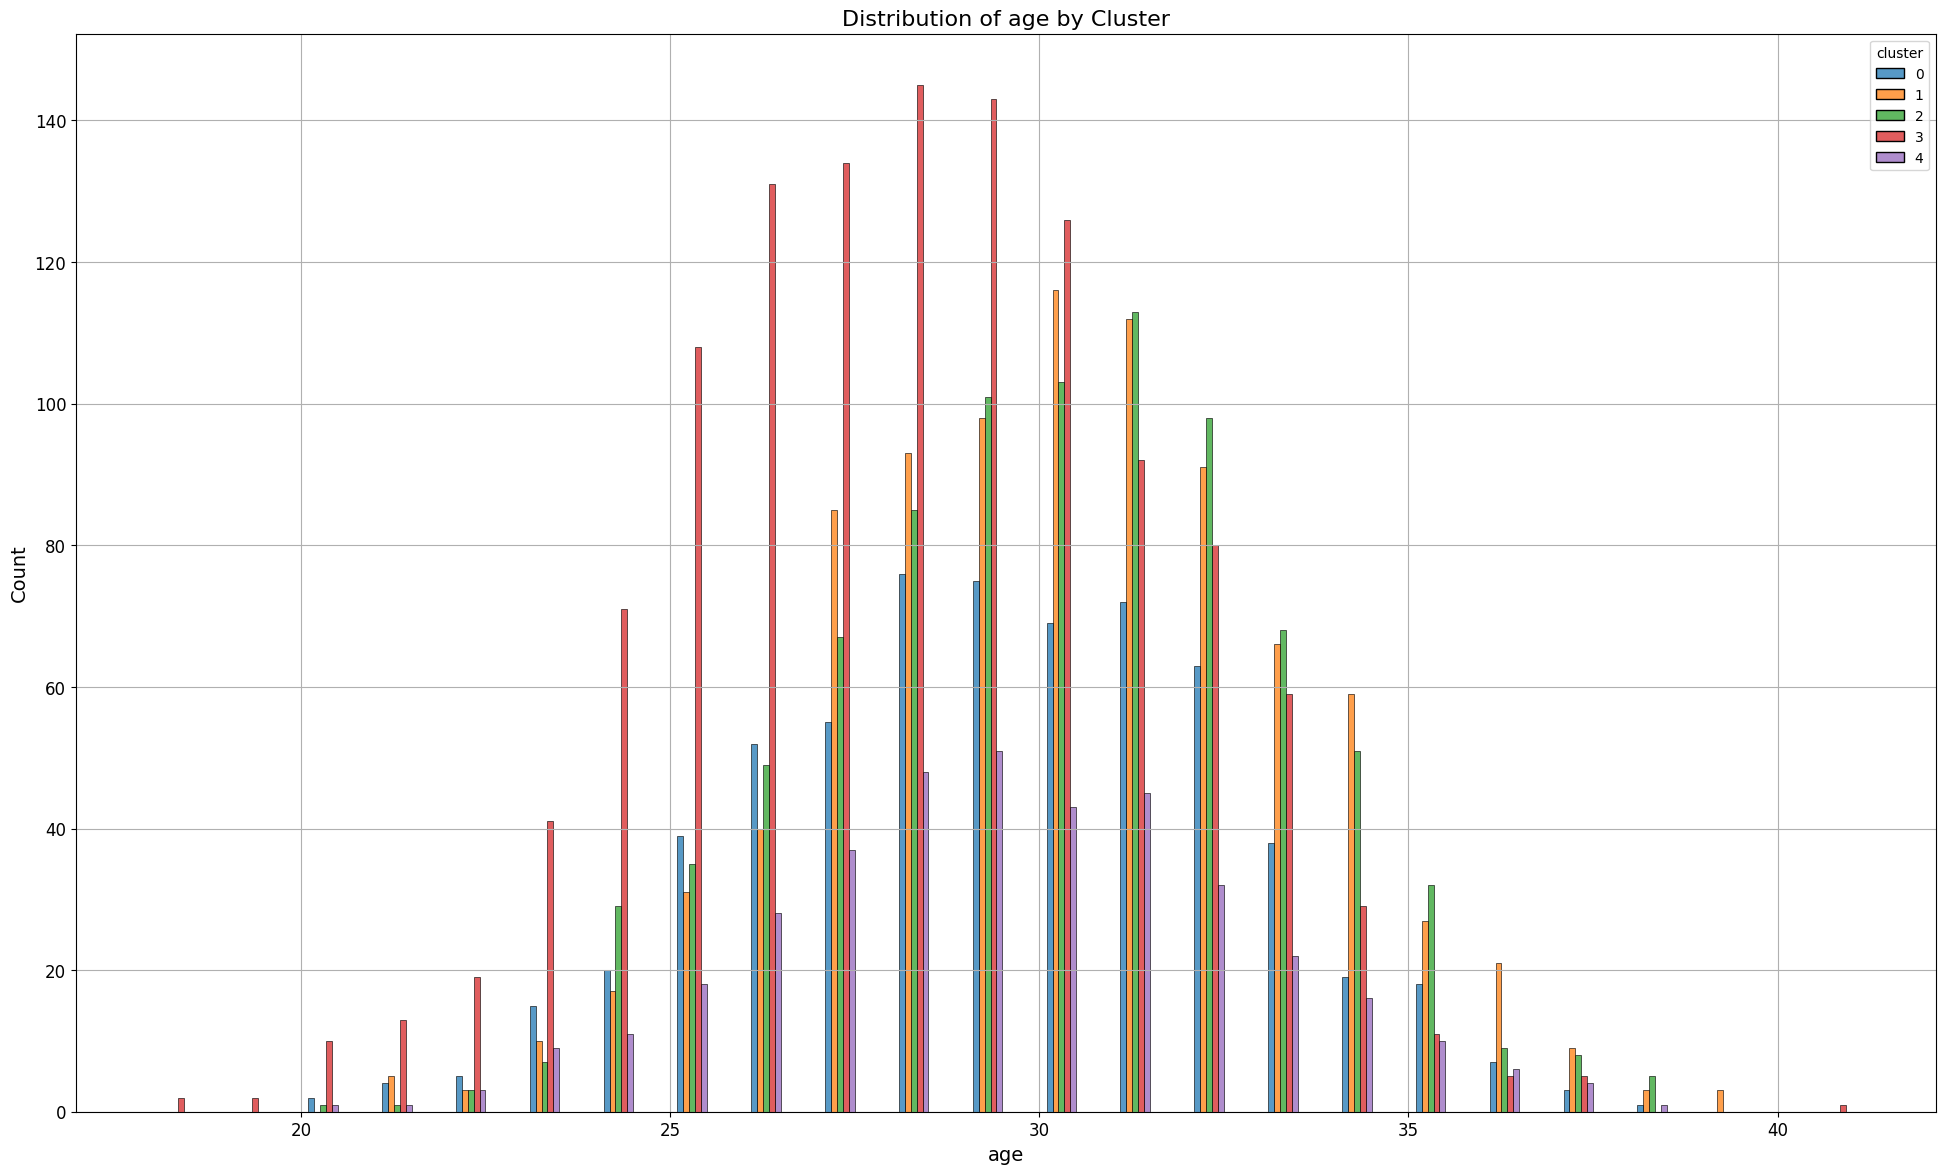

In [125]:
plot_feature_distribution(df, 'age')

We observe that the majority of customers are relatively young, with each cluster showing slight variations in average age.

**Practical Implications:**

- *Service Offerings*:
    - Clusters 0, 2, 4: Tailor services to young professionals in their late twenties. Offer fitness classes and programs that fit into their busy schedules. Highlight flexible membership options and convenient workout times;
    - Cluster 1: Focus on stability and routine in fitness programs. Offer classes and services that cater to young professionals in their early thirties looking for consistent workout routines and possibly family-oriented services;
    - Cluster 3: Provide services tailored to university students or recent graduates. Emphasize affordable membership options, flexible schedules, and high-energy group classes that cater to a younger demographic.

- *Marketing Strategies*:
    - Clusters 0, 2, 4: Use social media and digital marketing to reach young professionals. Highlight success stories and testimonials from customers in their late twenties;
    - Cluster 1: Use email marketing and professional networks to reach customers in their early thirties. Highlight the benefits of a stable fitness routine and potential family-friendly services;
    - Cluster 3: Leverage student discounts and campus partnerships to attract university students and recent graduates. Use vibrant and energetic marketing campaigns to engage this younger audience.

- *Retention Strategies*:
    - Clusters 0, 2, 4: Focus on engaging young professionals through personalized fitness plans, regular check-ins, and loyalty programs;
    - Cluster 1: Implement retention strategies that emphasize long-term benefits and consistent progress tracking. Offer membership plans that cater to both individuals and families;
    - Cluster 3: Engage younger customers with community-building activities, social events, and challenges that foster a sense of belonging and fun.

- *Customer Experience*:
    - Clusters 0, 2, 4: Create a vibrant and dynamic gym environment that appeals to young professionals. Offer modern facilities, cutting-edge fitness technology, and a variety of workout options;
    - Cluster 1: Provide a stable and welcoming gym environment that caters to the needs of early thirties professionals. Ensure that services are consistent and reliable;
    - Cluster 3: Create a fun and energetic atmosphere that appeals to younger customers. Offer trendy fitness classes, student-friendly amenities, and social spaces for interaction.

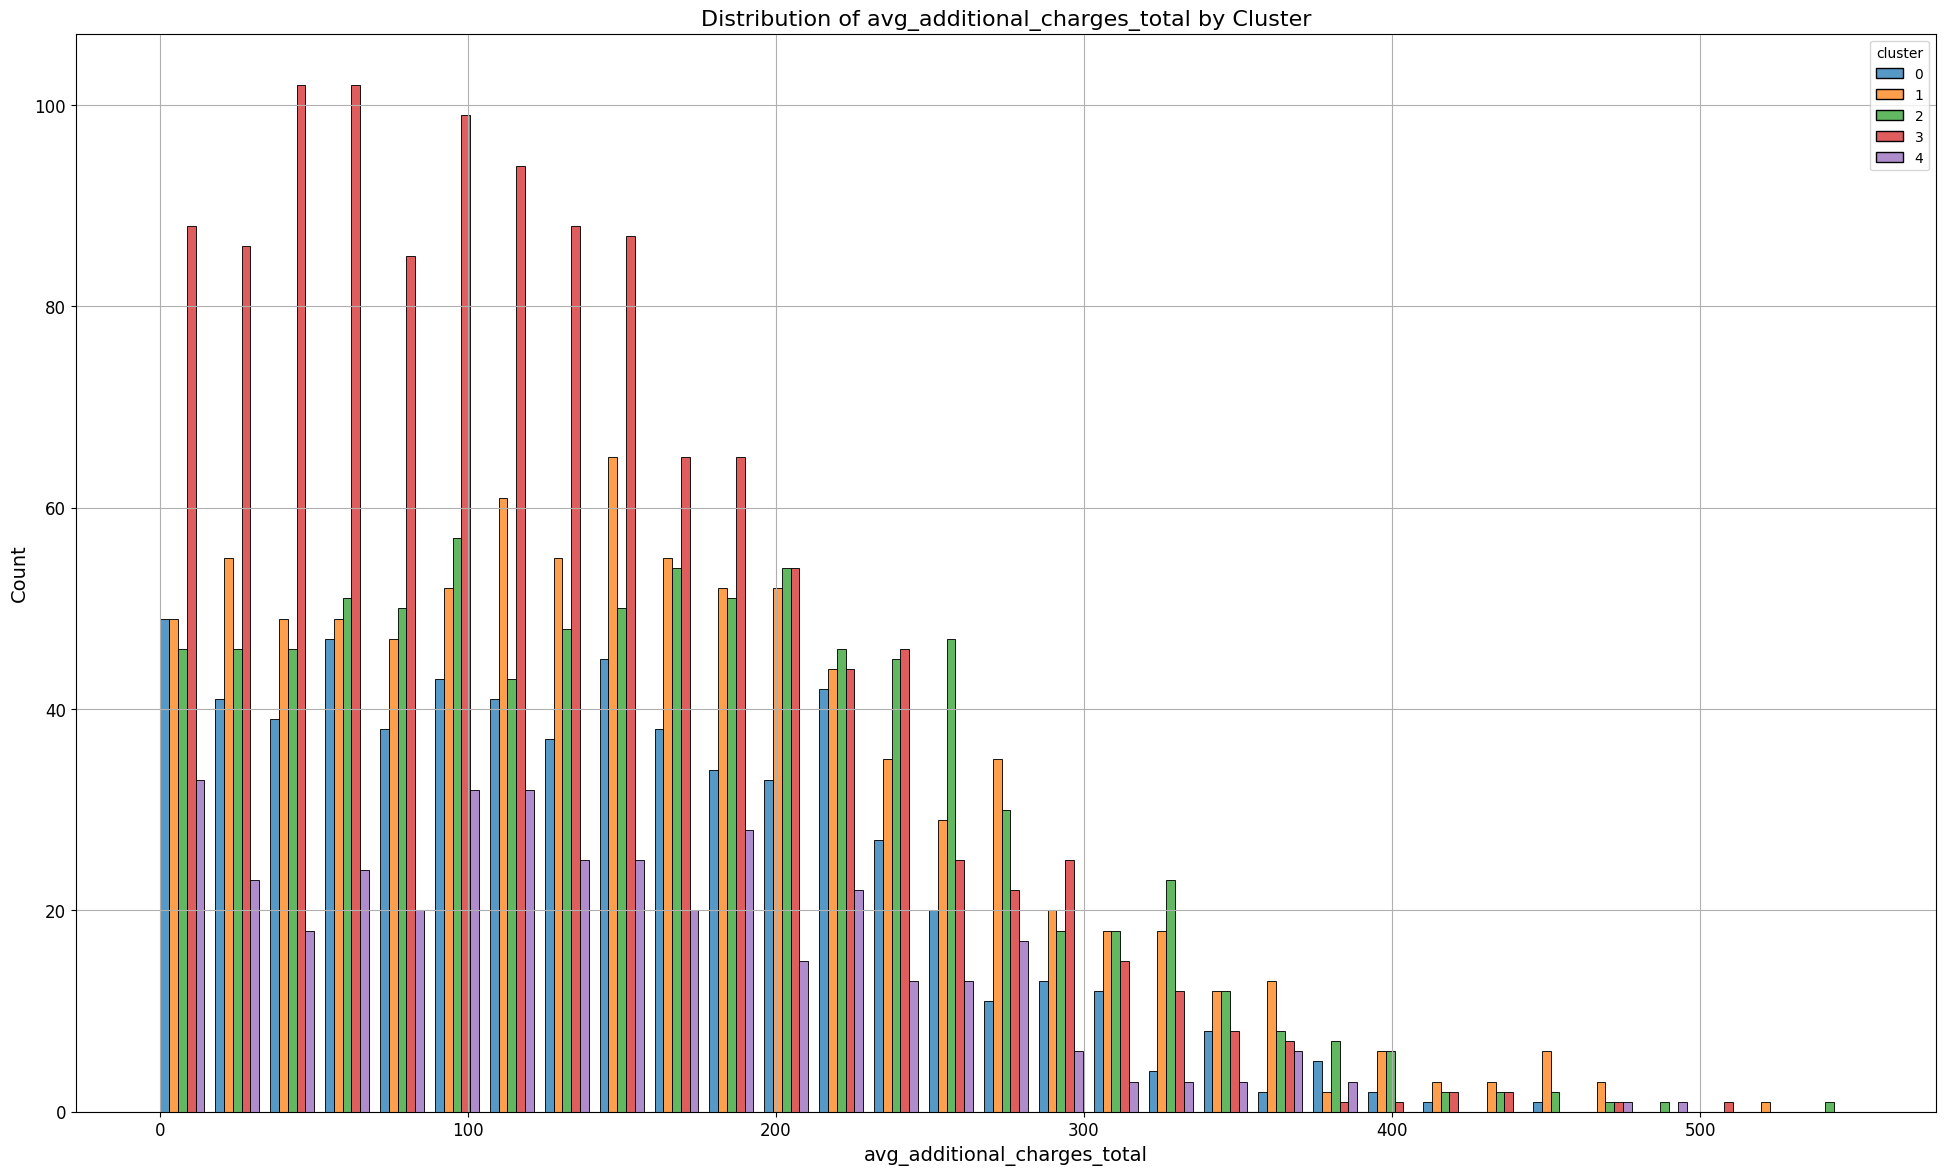

In [126]:
plot_feature_distribution(df, 'avg_additional_charges_total')

We observe varying levels of engagement with additional services. Cluster 2 has the highest spending, indicating strong engagement with premium offerings, while Cluster 3 has the lowest, indicating a preference for basic facilities. Clusters 0, 1, and 4 show moderate to high spending on additional services.

**Practical Implications:**

- *Service Promotion*:
    - Clusters 1 and 2: Promote premium services, special offers, and exclusive packages that cater to customers who are willing to spend more. Highlight the value and benefits of additional services such as personal training, spa treatments, and high-end gym merchandise;
    - Clusters 0 and 4: Maintain a balanced promotion strategy that includes both basic and premium services. Offer bundled packages that provide good value for moderate spenders;
    - Cluster 3: Focus on promoting the value of additional services to customers who typically stick to basic facilities. Provide introductory offers or discounts to encourage trial of these services.

- *Customer Engagement*:
    - Clusters 1 and 2: Engage high spenders with loyalty programs, exclusive events, and personalized communication. Recognize and reward their high engagement to foster loyalty and further spending;
    - Clusters 0 and 4: Provide personalized recommendations for additional services based on their moderate spending habits. Ensure a seamless and satisfying experience with the services they choose to use;
    - Cluster 3: Educate customers on the benefits of additional services through workshops, demos, and informative content. Highlight how these services can enhance their fitness journey.

- *Pricing Strategy*:
    - Clusters 1 and 2: Optimize pricing for premium services to maximize revenue from high spenders. Offer tiered pricing options that provide value at different spending levels;
    - Clusters 0 and 4: Provide competitively priced service bundles that appeal to moderate spenders. Ensure transparency in pricing to build trust and satisfaction;
    - Cluster 3: Offer affordable entry-level options for additional services to encourage initial trial. Use promotions and discounts to make these services more accessible.

- *Facility Improvement*:
    - Clusters 1 and 2: Continuously invest in upgrading premium facilities and services to meet the high expectations of top spenders. Ensure top-notch quality and service delivery;
    - Clusters 0 and 4: Maintain a good balance between basic and premium facilities to cater to a diverse customer base;
    - Cluster 3: Focus on maintaining high-quality basic facilities while gradually introducing additional services.

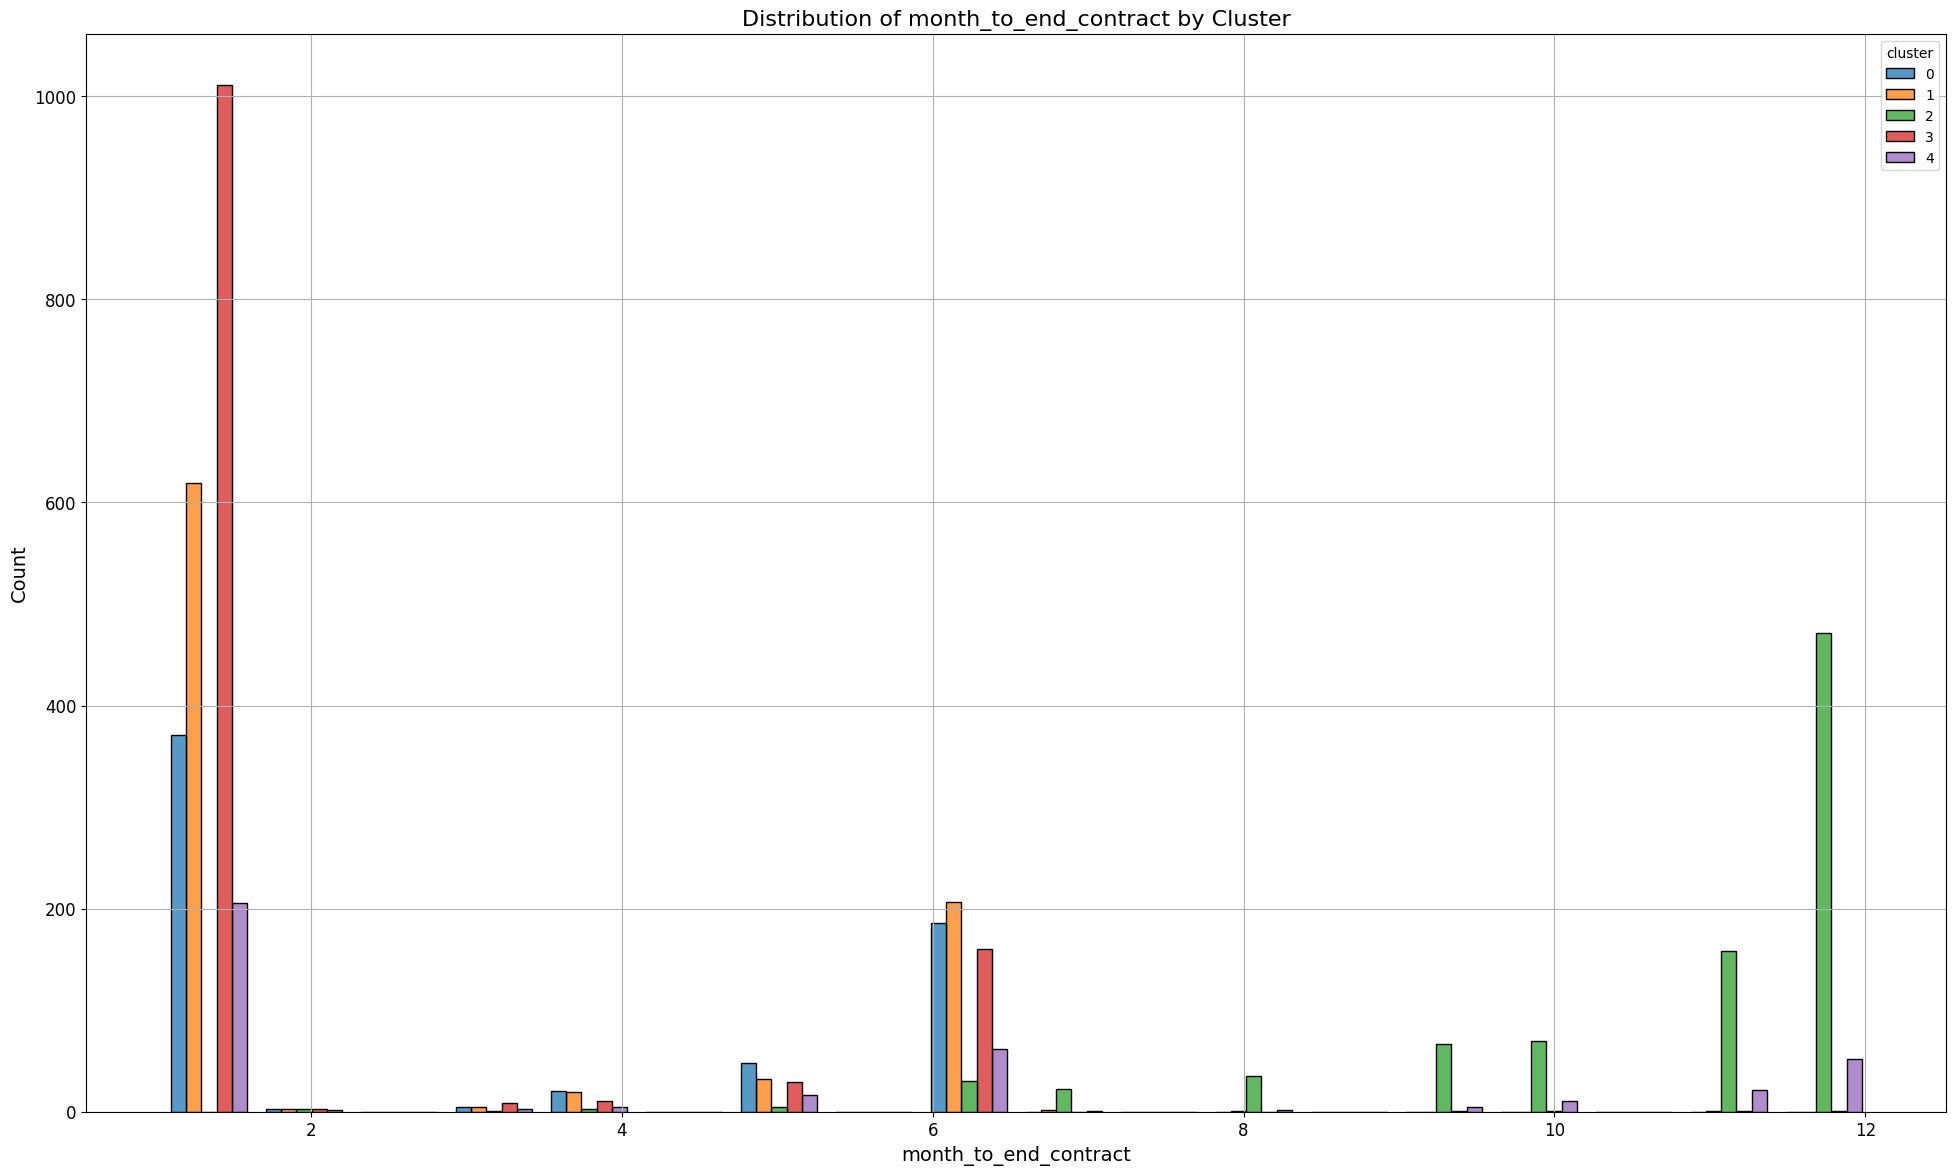

In [127]:
plot_feature_distribution(df, 'month_to_end_contract')

We observe varying levels of contract commitment. Cluster 2 has the highest number of months remaining, indicating long-term commitments, while Cluster 3 has the fewest, indicating potential risk for churn. Clusters 0, 1, and 4 have moderate to high remaining contract periods.

**Practical Implications:**

- *Renewal Strategies*:
    - Cluster 0: Engage customers with mid-term renewal offers and loyalty programs. Highlight the benefits of renewing their contracts early to lock in current rates or access special promotions;
    - Cluster 1: Similar to Cluster 0, focus on mid-term renewal strategies. Offer incentives for early renewal and emphasize the continuity of benefits;
    - Cluster 2: Maintain high engagement with long-term members through regular updates, personalized communication, and exclusive events. Ensure these customers feel valued and continue to see the benefits of their long-term commitment;
    - Cluster 3: Prioritize retention efforts for customers nearing the end of their contracts. Offer personalized renewal plans, discounts, and highlight new features or services to entice them to stay;
    - Cluster 4: Implement a balanced approach to renewal strategies, catering to both mid-term and long-term customers. Offer flexible renewal options and personalized incentives.

- *Customer Engagement*:
    - Cluster 0 & 1: Maintain consistent communication with mid-term customers, providing regular updates, service reminders, and engagement activities to keep them involved;
    - Cluster 2: Enhance engagement with long-term customers through loyalty programs, VIP events, and personalized fitness plans. Recognize and reward their long-term commitment;
    - Cluster 3: Increase engagement efforts with customers nearing the end of their contracts. Provide personalized outreach and support to address any concerns and encourage renewal;
    - Cluster 4: Offer a mix of engagement activities and personalized communication to cater to both mid-term and long-term customers.

- *Marketing and Promotions*:
    - Cluster 0 & 1: Use targeted marketing campaigns to promote mid-term renewal offers and highlight the benefits of continuing membership. Emphasize the value of staying committed;
    - Cluster 2: Focus on promoting the stability and long-term benefits of gym membership. Use testimonials and success stories from long-term members to attract new customers;
    - Cluster 3: Develop marketing strategies that address the specific needs and preferences of customers nearing the end of their contracts. Highlight new services, upcoming events, and special renewal offers;
    - Cluster 4: Implement marketing campaigns that cater to both mid-term and long-term customers. Offer flexible membership plans and highlight the benefits of renewing early.

- *Customer Service*:
    - Cluster 0 & 1: Ensure that mid-term customers receive excellent customer service and support. Address any issues promptly and provide personalized assistance to enhance their experience;
    - Cluster 2: Offer dedicated support for long-term customers. Provide regular check-ins and personalized service to ensure their satisfaction;
    - Cluster 3: Focus on providing exceptional customer service to customers nearing the end of their contracts. Address any concerns and offer personalized support to encourage renewal;
    - Cluster 4: Maintain high standards of customer service for both mid-term and long-term customers. Offer personalized assistance and support to meet their needs.

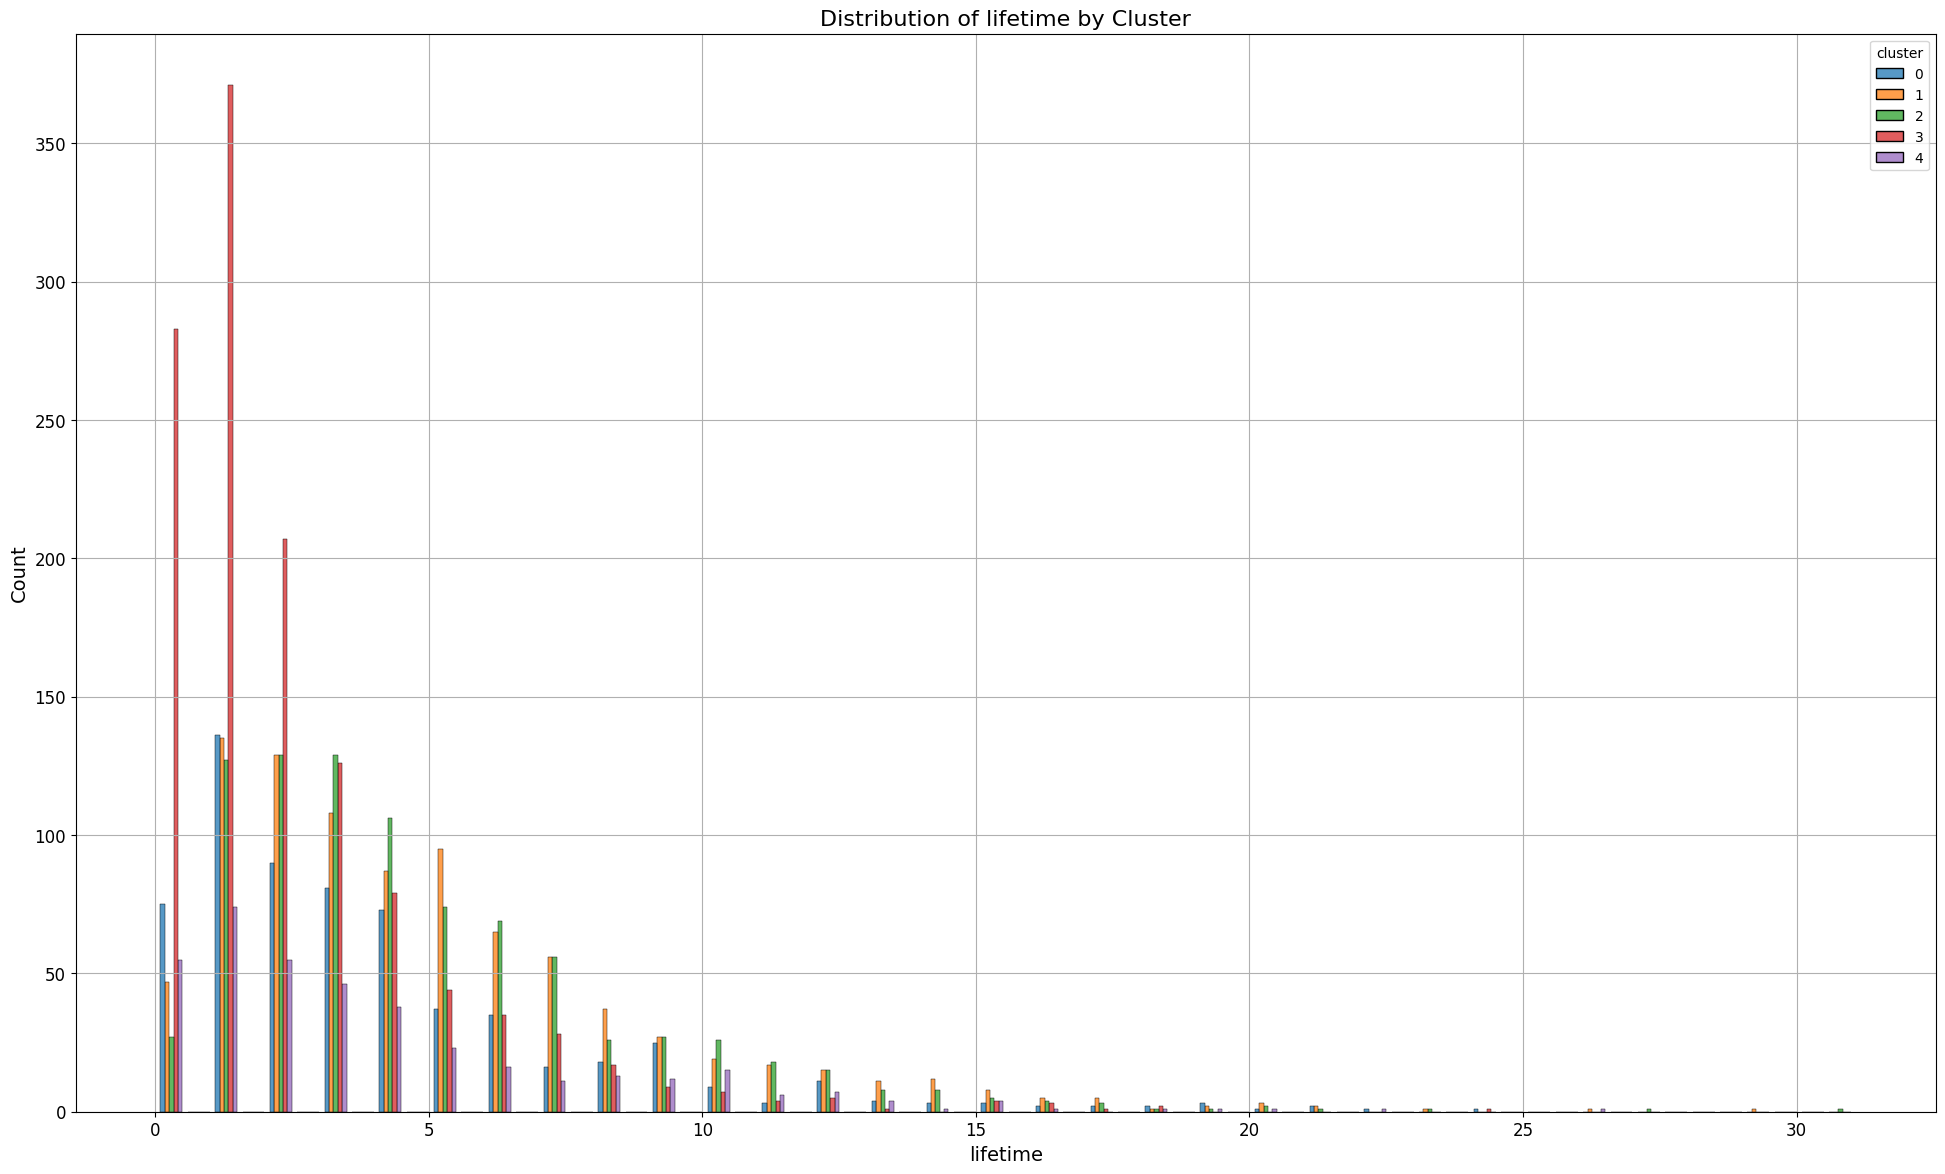

In [128]:
plot_feature_distribution(df, 'lifetime')

It may be hard to see but let's analyze this graph:

- Cluster 0 consists of relatively new members who have joined in the past few months. Expect to see a distribution peaking around 3.8 months;
- Customers in Cluster 1 have been members for slightly longer than those in Cluster 0, indicating moderate new membership. Expect to see a distribution peaking around 4.8 months;
- Similar to Cluster 1, Cluster 2's these customers are also relatively new members. Expect to see a distribution peaking around 4.7 months;
- Cluster 3 has the newest members who have joined very recently. Expect to see a distribution peaking around 2.2 months;
- Customers in Cluster 4 have been members for a moderate amount of time, similar to Cluster 0.

**Practical Implications:**

- *Retention Strategies*:
    - Cluster 0: Focus on engaging new members through welcome programs, orientation sessions, and regular check-ins. Offer incentives to encourage early commitment and continued membership;
    - Cluster 1: Implement engagement strategies for members who have been around for a few months. Highlight progress and milestones achieved, and offer personalized fitness plans to maintain interest;
    - Cluster 2: Similar to Cluster 1, provide support and encouragement to retain these relatively new members. Emphasize the benefits of staying committed;
    - Cluster 3: Prioritize retention efforts for the newest members. Provide strong onboarding support, regular follow-ups, and early engagement activities to build a strong connection with the gym;
    - Cluster 4: Engage members through targeted programs and personalized communication. Highlight the benefits of continued membership and offer renewal incentives.

- *Customer Engagement*:
    - Cluster 0: Maintain high engagement through regular updates, progress tracking, and community-building activities. Ensure new members feel welcomed and supported;
    - Cluster 1: Enhance engagement by offering personalized fitness plans, progress reviews, and group activities. Keep members motivated with regular challenges and rewards;
    - Cluster 2: Focus on personalized engagement strategies to maintain interest. Offer tailored fitness programs and regular progress updates;
    - Cluster 3: Provide a strong onboarding experience and continuous support to ensure new members feel valued. Regularly check in with new members to address any concerns;
    - Cluster 4: Offer a mix of engagement activities, including fitness challenges, social events, and personalized coaching. Highlight member achievements and provide ongoing support.

- *Marketing and Promotions*:
    - Cluster 0: Use marketing campaigns to attract new members and highlight the benefits of joining the gym. Offer special promotions and discounts for new sign-ups;
    - Cluster 1: Promote the gym's supportive community and personalized fitness plans. Highlight success stories and testimonials from relatively new members;
    - Cluster 2: Emphasize the gym's welcoming environment and the benefits of long-term membership. Offer incentives for continued commitment;
    - Cluster 3: Develop marketing strategies that appeal to the newest members. Highlight the gym's onboarding support and community atmosphere;
    - Cluster 4: Use a balanced approach to marketing, focusing on both new member benefits and the advantages of continued membership. Offer renewal incentives and highlight member achievements.

- *Customer Experience*:
    - Cluster 0: Ensure new members have a positive experience from the start. Provide excellent customer service, high-quality facilities, and a welcoming atmosphere;
    - Cluster 1: Focus on maintaining a high level of service and support. Offer personalized fitness plans, regular check-ins, and community-building activities;
    - Cluster 2: Enhance the customer experience by providing tailored fitness programs and regular progress updates. Maintain a welcoming and supportive environment;
    - Cluster 3: Provide a strong onboarding experience and continuous support. Ensure new members feel valued and supported throughout their fitness journey;
    - Cluster 4: Offer a mix of personalized support, community-building activities, and ongoing engagement. Highlight member achievements and provide excellent customer service.

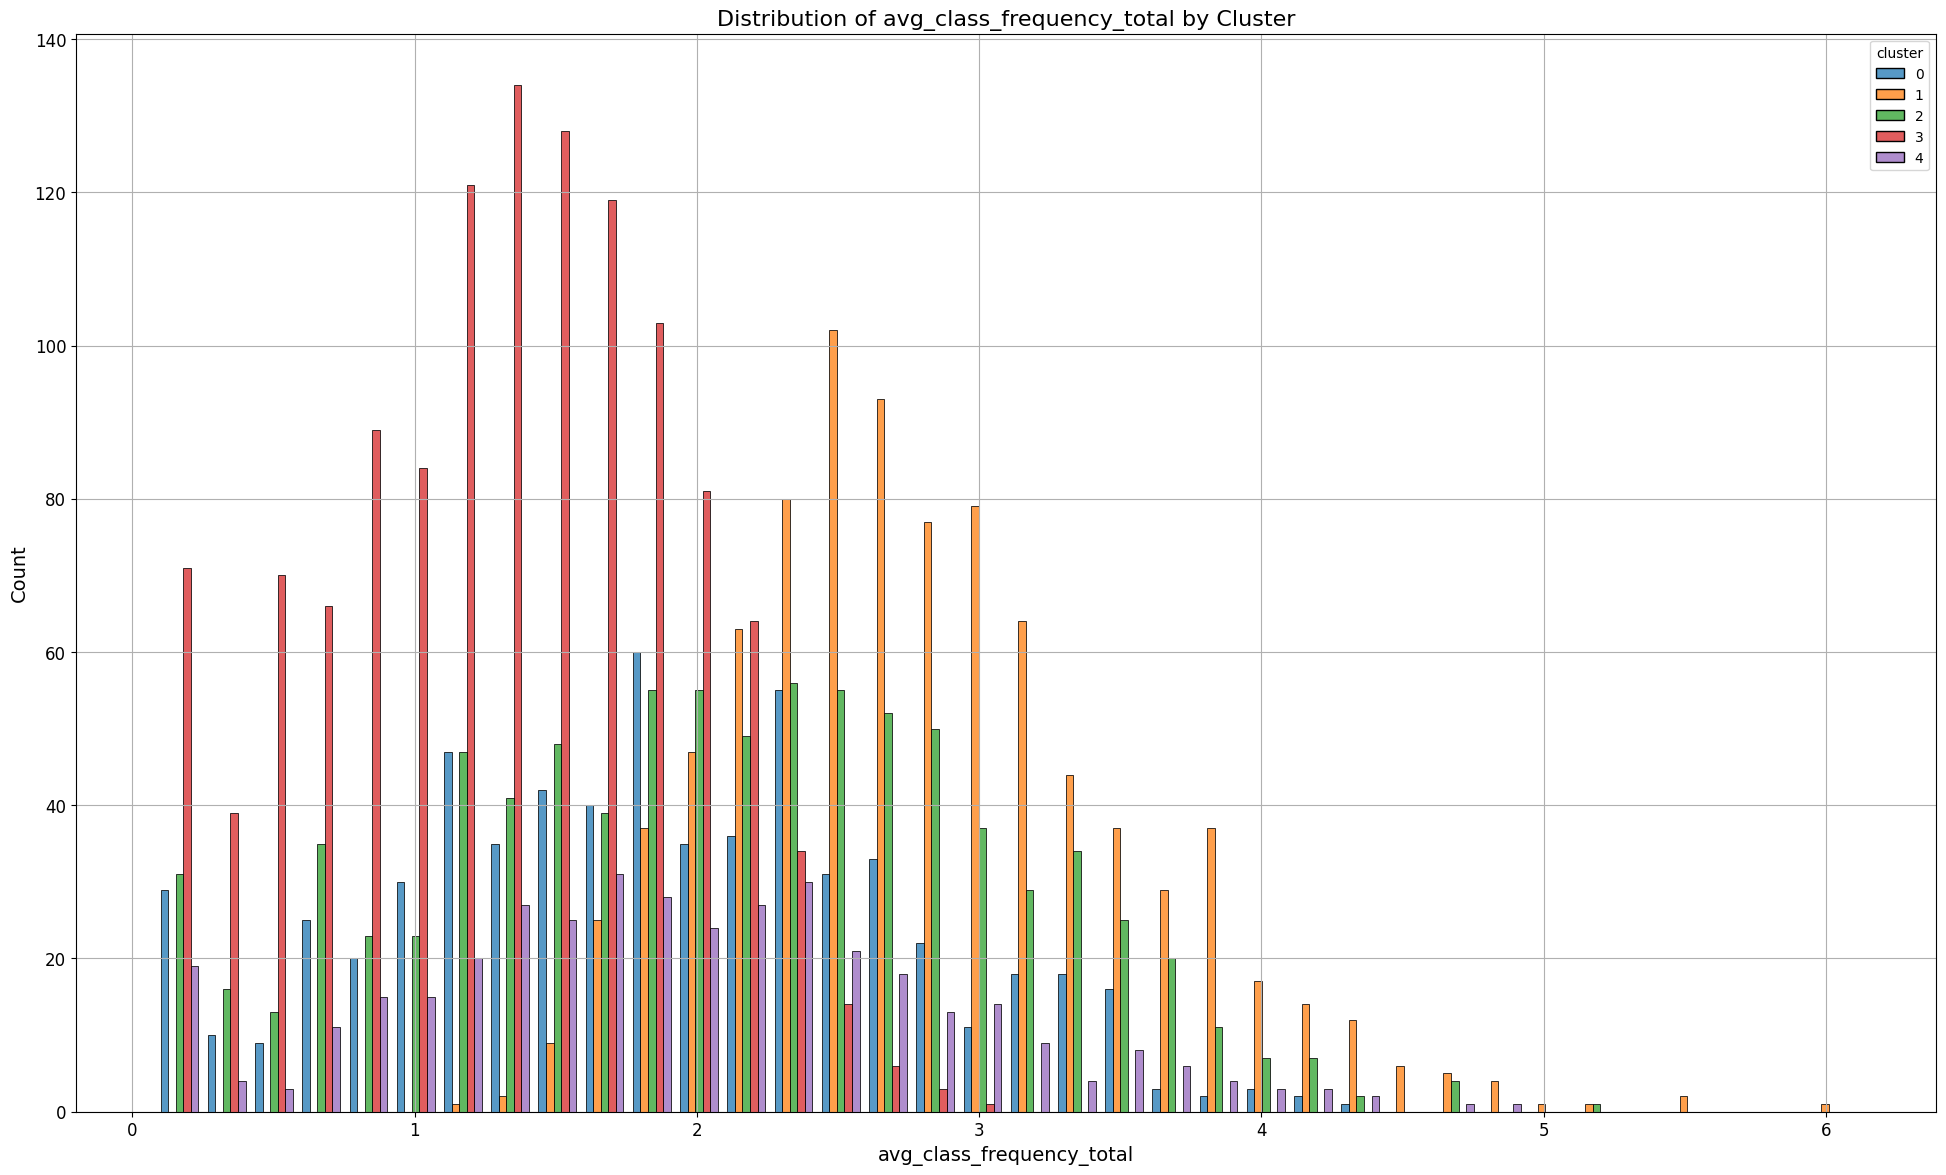

In [131]:
plot_feature_distribution(df, 'avg_class_frequency_total')

Let's analyze this graph:
- Cluster 0 consists of customers who visit the gym moderately frequently, distribution is peaking around 1.8 times per week;
- Customers in Cluster 1 are highly engaged, visiting the gym frequently, distribution is peaking around 2.7 times per week;
- Customers in Cluster 2 have a moderate to high frequency of gym visits, distribution is peaking around 2 times per week;
- Cluster 3 has the lowest frequency of gym visits, indicating lower engagement, distribution is peaking around 1.2 times per week;
- Customers in Cluster 4 have a moderate level of engagement, similar to Cluster 0. 

**Practical Implications:**

- *Engagement Strategies*:
    - Cluster 0: Implement engagement strategies to increase visit frequency. Offer incentives for more frequent visits, such as rewards for achieving a certain number of visits per month.
    - Cluster 1: Maintain high engagement with these highly active members. Offer advanced fitness programs and challenges to keep them motivated and engaged.
    - Cluster 2: Encourage consistent engagement by providing personalized fitness plans and regular progress updates. Highlight the benefits of maintaining a high visit frequency.
    - Cluster 3: Focus on increasing the engagement of low-frequency visitors. Offer personalized outreach, beginner-friendly classes, and incentives to encourage more frequent visits.
    - Cluster 4: Provide support to maintain and slightly increase their engagement level. Offer flexible workout schedules and varied class options to keep them interested.

- *Retention Strategies*:
    - Cluster 0: Focus on retaining these moderately engaged members by offering regular check-ins and personalized fitness advice.
    - Cluster 1: Retain highly engaged members by recognizing their commitment and offering exclusive benefits and loyalty programs.
    - Cluster 2: Provide consistent support and engagement to retain these moderately to highly engaged members. Offer personalized fitness goals and milestones.
    - Cluster 3: Prioritize retention strategies for low-engagement members by addressing barriers to more frequent visits and offering motivational incentives.
    - Cluster 4: Implement retention strategies that emphasize flexibility and convenience to maintain and improve engagement levels.

- *Marketing and Promotions*:
    - Cluster 0: Use marketing campaigns that highlight the benefits of regular gym visits and offer incentives for increased frequency.
    - Cluster 1: Promote advanced and exclusive fitness programs to highly engaged members. Highlight success stories and testimonials from frequent visitors.
    - Cluster 2: Emphasize the benefits of consistent gym visits and offer promotions that reward regular attendance.
    - Cluster 3: Develop marketing strategies that address the needs of low-frequency visitors. Highlight beginner programs, flexible schedules, and supportive community.
    - Cluster 4: Promote a variety of fitness options and flexible membership plans to encourage consistent engagement.

- *Customer Experience*:
    - Cluster 0: Ensure a positive and supportive experience for moderately engaged members. Offer regular feedback and personalized support.
    - Cluster 1: Provide a dynamic and challenging environment for highly engaged members. Offer advanced classes and exclusive events.
    - Cluster 2: Focus on creating a welcoming and motivating atmosphere. Provide regular updates and personalized fitness plans.
    - Cluster 3: Create a supportive and encouraging environment for low-engagement members. Offer beginner-friendly classes and personalized outreach.
    - Cluster 4: Provide a variety of fitness options and flexible schedules to cater to the needs of moderately engaged members.

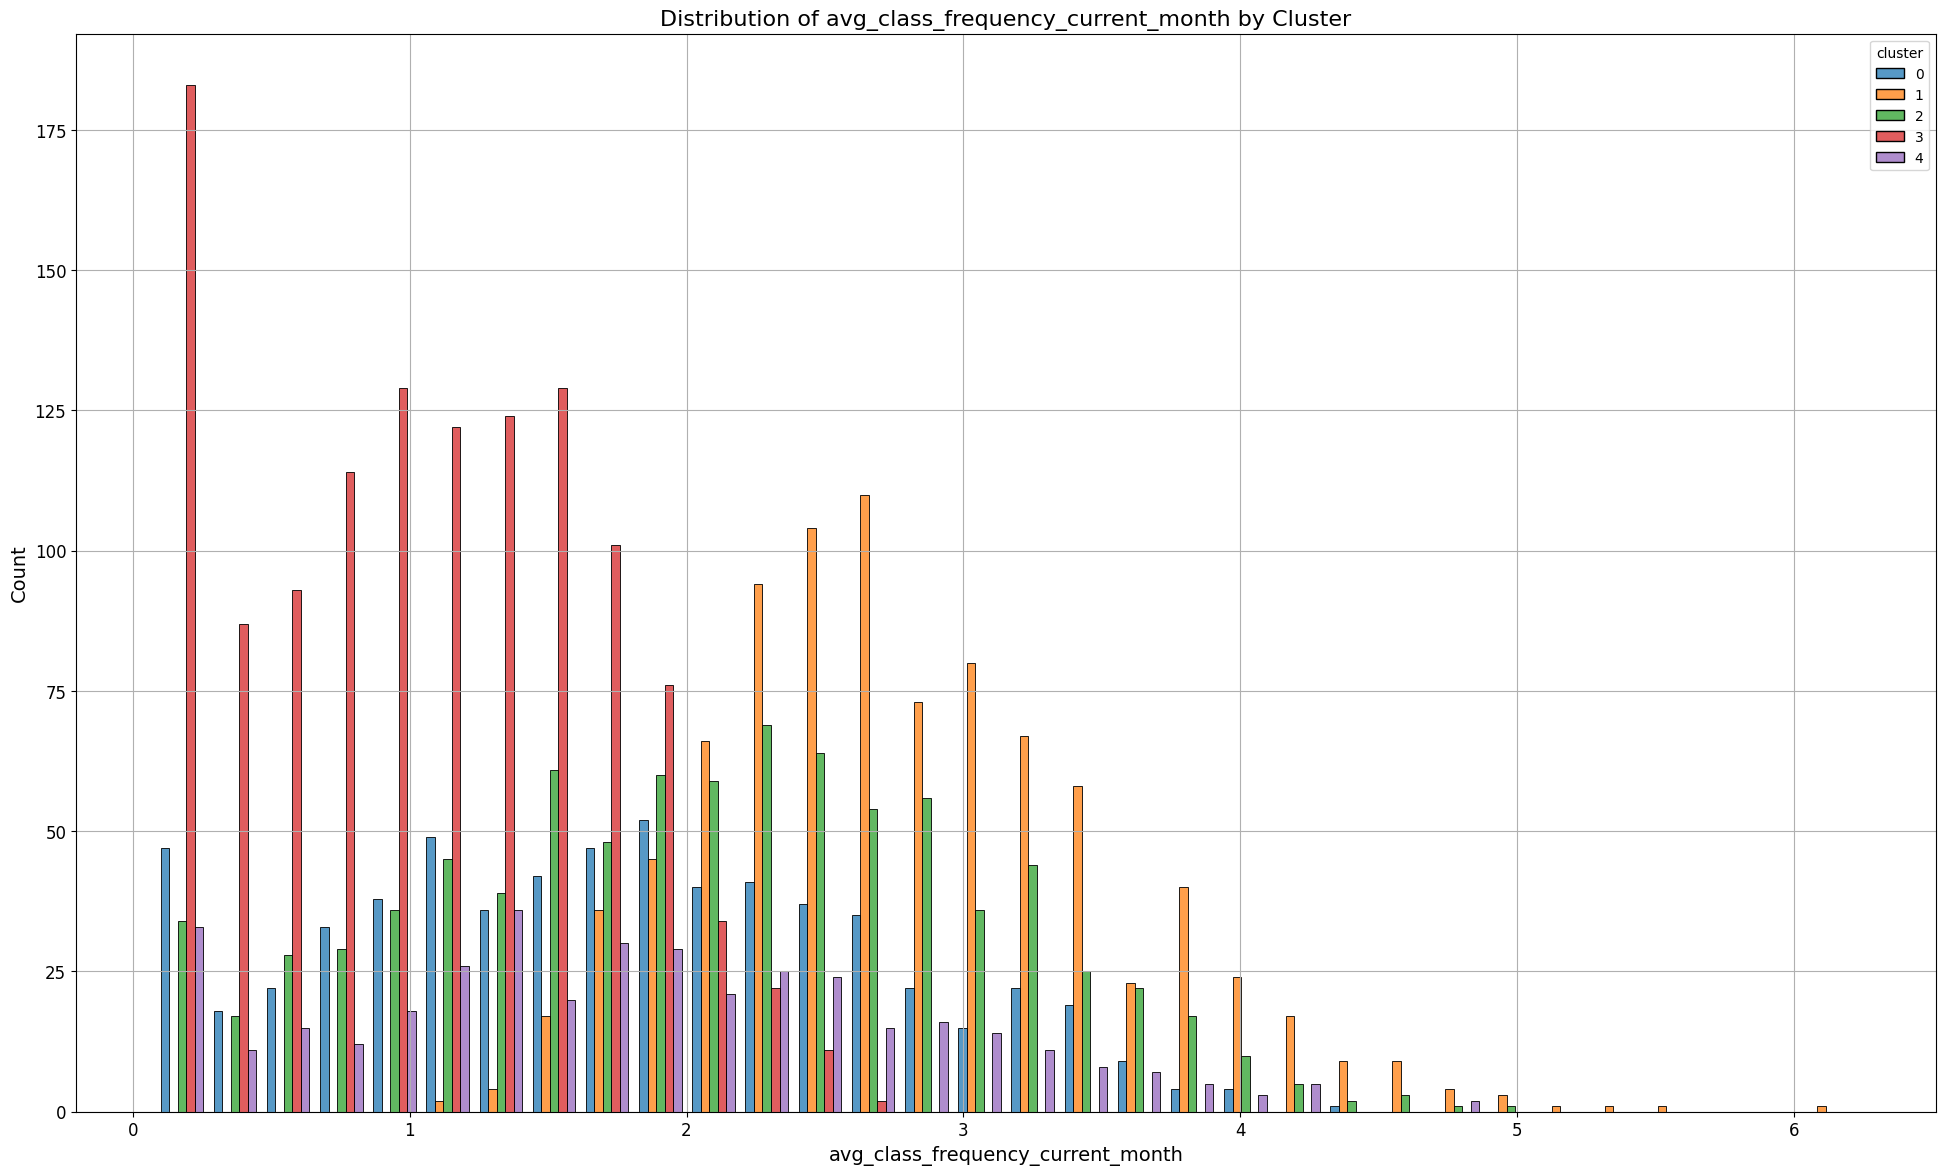

In [130]:
plot_feature_distribution(df, 'avg_class_frequency_current_month')

Let's analyze this graph:
- Cluster 0 consists of customers with moderate engagement levels in the current month;
- Customers in Cluster 1 are highly engaged, visiting the gym frequently in the current month;
- Customers in Cluster 2 have a moderate to high frequency of gym visits in the current month;
- Cluster 3 has the lowest frequency of gym visits in the current month, indicating low engagement;
- Customers in Cluster 4 have moderate engagement levels in the current month.

**Practical Implications:**

- *Engagement Strategies*:
    - Cluster 0: Encourage moderate engagement by offering incentives for increased visit frequency. Highlight the benefits of consistent gym attendance and offer regular challenges or rewards.
    - Cluster 1: Maintain high engagement by providing advanced fitness programs, personalized coaching, and exclusive events. Recognize and reward the commitment of highly engaged members.
    - Cluster 2: Support and encourage moderate to high engagement through personalized fitness plans, regular check-ins, and progress tracking. Emphasize the benefits of maintaining a high visit frequency.
    - Cluster 3: Focus on increasing the engagement of low-frequency visitors. Offer personalized outreach, beginner-friendly classes, and incentives to encourage more frequent visits.
    - Cluster 4: Maintain and slightly increase engagement levels by providing flexible workout schedules, varied class options, and personalized support.

- *Retention Strategies*:
    - Cluster 0: Focus on retaining moderately engaged members by offering personalized fitness advice, regular check-ins, and tailored engagement activities.
    - Cluster 1: Retain highly engaged members by recognizing their commitment and offering exclusive benefits, loyalty programs, and advanced fitness challenges.
    - Cluster 2: Provide consistent support and engagement to retain moderately to highly engaged members. Offer personalized fitness goals and milestones.
    - Cluster 3: Prioritize retention strategies for low-engagement members by addressing barriers to more frequent visits and offering motivational incentives.
    - Cluster 4: Implement retention strategies that emphasize flexibility and convenience to maintain and improve engagement levels.

- *Marketing and Promotions*:
    - Cluster 0: Use marketing campaigns that highlight the benefits of regular gym visits and offer incentives for increased frequency.
    - Cluster 1: Promote advanced and exclusive fitness programs to highly engaged members. Highlight success stories and testimonials from frequent visitors.
    - Cluster 2: Emphasize the benefits of consistent gym visits and offer promotions that reward regular attendance.
    - Cluster 3: Develop marketing strategies that address the needs of low-frequency visitors. Highlight beginner programs, flexible schedules, and supportive community.
    - Cluster 4: Promote a variety of fitness options and flexible membership plans to encourage consistent engagement.

- *Customer Experience*:
    - Cluster 0: Ensure a positive and supportive experience for moderately engaged members. Offer regular feedback and personalized support.
    - Cluster 1: Provide a dynamic and challenging environment for highly engaged members. Offer advanced classes and exclusive events.
    - Cluster 2: Focus on creating a welcoming and motivating atmosphere. Provide regular updates and personalized fitness plans.
    - Cluster 3: Create a supportive and encouraging environment for low-engagement members. Offer beginner-friendly classes and personalized outreach.
    - Cluster 4: Provide a variety of fitness options and flexible schedules to cater to the needs of moderately engaged members.

#### Calculating the churn rate for each cluster and comparing them.

In [133]:
# Calcuating churn rate for each cluster

df.groupby('cluster')['churn'].mean().sort_values(ascending=False)

cluster
3    0.572942
4    0.266839
0    0.246445
1    0.089989
2    0.021965
Name: churn, dtype: float64

Let's not forget each cluster's size, here it is printed again.

In [134]:
# Displaying each cluster size

print('Cluster 0 size :',df[df.cluster == 0].shape)
print()
print('Cluster 1 size :',df[df.cluster == 1].shape)
print()
print('Cluster 2 size :',df[df.cluster == 2].shape)
print()
print('Cluster 3 size :',df[df.cluster == 3].shape)
print()
print('Cluster 4 size :',df[df.cluster == 4].shape)

Cluster 0 size : (633, 15)

Cluster 1 size : (889, 15)

Cluster 2 size : (865, 15)

Cluster 3 size : (1227, 15)

Cluster 4 size : (386, 15)


Let's analyze and rate the clusters based on their loyalty:
1. Cluster 2 has a substantial size with the lowest churn rate, indicating very loyal members. Maintaining high engagement and satisfaction in this cluster is crucial;
2. Cluster 1 is the second-largest cluster with a low churn rate. These members are loyal, and efforts should be made to maintain their satisfaction and engagement;
3. With a moderate size and a moderate churn rate, Cluster 0 has a significant number of members at risk of leaving. Retention strategies should focus on this cluster to prevent substantial losses;
4. Cluster 4 is the smallest cluster with a moderate to high churn rate. Although smaller in size, this cluster still requires attention to reduce churn;
5. Cluster 3 is the largest cluster with the highest churn rate. This indicates a significant risk, and immediate retention efforts are needed to address the high churn rate.

**Practical Implications:**

- *Retention Strategies*:
    - Cluster 3: With the largest size and highest churn rate, this cluster should be the top priority for retention efforts. Implement personalized outreach, identify common reasons for churn, and address them promptly;
    - Cluster 0: Moderate size and churn rate indicate a need for targeted retention programs. Offer loyalty rewards, personalized fitness plans, and regular check-ins to reduce churn;
    - Cluster 4: Despite being the smallest cluster, the moderate to high churn rate requires attention. Focus on understanding the specific needs of these members and offering tailored incentives to retain them.

- *Engagement and Support*:
    - Clusters 1 and 2: These clusters are large and loyal, with low churn rates. Maintain high engagement through personalized communication, rewards programs, and recognition of their loyalty;
    - Cluster 0: Provide consistent support and engagement activities to retain moderately loyal members;
    - Cluster 4: Ensure personalized support and regular engagement to address concerns and improve satisfaction.

- *Marketing and Promotions*:
    - Cluster 3: Develop targeted marketing campaigns to re-engage at-risk customers. Highlight the benefits of staying and offer special promotions to encourage renewal;
    - Cluster 4: Use marketing efforts to emphasize the value and benefits of continued membership. Offer incentives to reduce the risk of churn;
    - Clusters 1 and 2: Promote testimonials and success stories from these loyal customers to attract new members and reinforce their positive experiences.

- *Resource Allocation*:
    - Cluster 3: Allocate more resources to address the high churn rate, such as additional customer service representatives, personalized retention offers, and more frequent check-ins;
    - Cluster 0 and 4: Allocate resources to implement effective retention strategies, focusing on understanding and addressing the specific reasons for churn in these clusters;
    - Clusters 1 and 2: Maintain resource allocation to ensure continued engagement and satisfaction among loyal members.

**Summary:**

- *High Risk of Leaving*:
    - Cluster 3: Largest cluster with the highest churn rate, requiring immediate retention efforts;
    - Cluster 0: Moderate size with a moderate churn rate, indicating a need for targeted retention strategies;
    - Cluster 4: Smallest cluster with a moderate to high churn rate, requiring focused retention efforts.

- *Loyal Customers*:
    - Cluster 2: Large size with the lowest churn rate, indicating very loyal customers;
    - Cluster 1: Largest cluster with a low churn rate, indicating loyal customers.

By considering both churn rates and cluster sizes, we can prioritize retention strategies and resource allocation to effectively address the needs of each cluster, ultimately enhancing customer satisfaction and loyalty.

### Coming up with conclusions and basic recommendations on working with customers.

#### Conclusions:

- *Cluster 0 (Moderate Churn Rate, Moderate Size)*:
    - Churn Rate: 24.6%;
    - Size: 633 members;
    - Characteristics: Moderate engagement, relatively new members;
    - Conclusion: Cluster 0 members are moderately at risk of leaving. They engage with the gym services at an average level.

- *Cluster 1 (Low Churn Rate, Large Size)*:
    - Churn Rate: 9.0%;
    - Size: 889 members;
    - Characteristics: High engagement, relatively new members;
    - Conclusion: Cluster 1 members are loyal and highly engaged. They represent a stable customer base with a low risk of churn.

- *Cluster 2 (Very Low Churn Rate, Large Size)*:
    - Churn Rate: 2.2%;
    - Size: 865 members;
    - Characteristics: High engagement, long-term commitments;
    - Conclusion: Cluster 2 members are very loyal and highly engaged. They are the most stable and committed customers.

- *Cluster 3 (High Churn Rate, Largest Size)*:
    - Churn Rate: 57.3%;
    - Size: 1227 members;
    - Characteristics: Low engagement, relatively new members;
    - Conclusion: Cluster 3 members are at high risk of leaving. They represent the largest group but are the least engaged and most likely to churn.

- *Cluster 4 (Moderate to High Churn Rate, Smallest Size)*:
    - Churn Rate: 26.7%;
    - Size: 386 members;
    - Characteristics: Moderate engagement, mix of mid-term and long-term commitments;
    - Conclusion: Cluster 4 members have a moderate to high risk of leaving. Despite being the smallest group, they require focused retention efforts.

#### Recommendations:

- *Cluster 0*:
    - Retention Strategies: Implement loyalty programs, offer regular progress updates, and provide personalized fitness advice;
    - Engagement Strategies: Introduce incentives for increased visit frequency, such as challenges or rewards for regular attendance;
    - Communication: Maintain regular contact through personalized emails and check-ins.

- *Cluster 1*:
    - Retention Strategies: Continue recognizing their loyalty with exclusive benefits and advanced fitness programs;
    - Engagement Strategies: Offer new and advanced fitness challenges to maintain their interest and engagement;
    - Communication: Regularly update them on new services and programs, and solicit feedback to ensure their needs are met.

- *Cluster 2*:
    - Retention Strategies: Focus on maintaining high satisfaction through personalized services and recognition programs;
    - Engagement Strategies: Offer VIP events, loyalty rewards, and personalized fitness plans;
    - Communication: Ensure continuous engagement with regular updates and exclusive content.

- *Cluster 3*:
    - Retention Strategies: Prioritize personalized outreach and support, address common reasons for churn, and offer incentives to stay;
    - Engagement Strategies: Introduce beginner-friendly classes, provide regular follow-ups, and offer motivational incentives;
    - Communication: Engage through personalized communication, addressing individual needs and concerns.

- *Cluster 4*:
    - Retention Strategies: Focus on understanding their specific needs and providing tailored incentives to reduce churn;
    - Engagement Strategies: Offer flexible workout schedules, varied class options, and personalized support;
    - Communication: Maintain regular contact and provide personalized engagement to address concerns and improve satisfaction.